### Read Features 

In [ ]:
import pickle
with open('cds_DNA_features_dic.pkl', 'rb') as f:    
    cds_features_dic = pickle.load(f)

with open('cds_pro_features_dic.pkl', 'rb') as f:    
    cds_pro_features_dic = pickle.load(f)

with open('cds_structure_features_dic_1800.pkl', 'rb') as f:    
    cds_3d_features_dic = pickle.load(f)

### Get common gene list 

In [156]:
intersection = set(cds_features_dic.keys()).intersection(cds_pro_features_dic.keys(), cds_3d_features_dic.keys())

common_list = list(intersection)


In [157]:
len(common_list)

19489

### SR gene pair label as 1 and Non SR label as 0 

In [159]:
# SR as '1' sample
import pandas as pd
SR = {}
# Load spreadsheet
xl = pd.ExcelFile('all_cancer_pair.xlsx')

df = xl.parse(xl.sheet_names[0], skiprows=3)

for index, row in df.iterrows():
# Use the first and second column values as a key, and set the value as 1
    SR[row[0], row[1]] = 1

    
df = xl.parse(xl.sheet_names[2], skiprows=2)

for index, row in df.iterrows():
# Use the first and second column values as a key, and set the value as 1
    SR[row[0], row[1]] = 1
    

print(len(SR))

/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


3000


/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [161]:
nocds_SR = []
for k,v in SR.items():
    if k[0] not in common_list or k[1] not in common_list:
        nocds_SR.append(k)
for i in nocds_SR:
    del SR[i]
print(len(SR))
    

2749


In [162]:
# Non-SR as '0' sample
from Bio import SeqIO

def extract_gene_symbol(description):
    parts = description.split(' ')
    for part in parts:
        if part.startswith('gene_symbol:'):
            return part.split(':')[1]
    return None

fasta_file = "Homocdsall.fasta"  

cds_dic = {}
for record in SeqIO.parse(fasta_file, "fasta"):
    gene_symbol = extract_gene_symbol(record.description)
    cds_dic[gene_symbol] = str(record.seq)
    
cds_gene_list = []
for k,v in cds_dic.items():       
        cds_gene_list.append(k)
cds_gene_list = list(set(cds_gene_list))
print(len(cds_gene_list))

import random

Non_SR = {}
random.seed(127)
for i in range(27490-2749):
    a = random.randint(0, 19488)
    b = random.randint(0, 19488)
    while a == b:
        b = random.randint(0, 19488)
    if (common_list[a], common_list[b]) not in SR:
        
        Non_SR[common_list[a], common_list[b]] = 0
    
print(len(Non_SR))

19853
24740


### Test Performance  

In [166]:
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d,e,f]))
        y.append(label)        
    except:
        print(gene_pair)
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d,e,f]))
        y.append(label)        
    except:
        print(gene_pair)

100%|████████████████████████████████████████████████████| 24740/24740 [00:00<00:00, 34916.90it/s]


In [164]:
y.count(1)

2749

#### Performance Test 

one-time

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

train_loss 0.328 validation_loss 0.241
train_loss 0.116 validation_loss 0.192
train_loss 0.055 validation_loss 0.195
train_loss 0.028 validation_loss 0.202


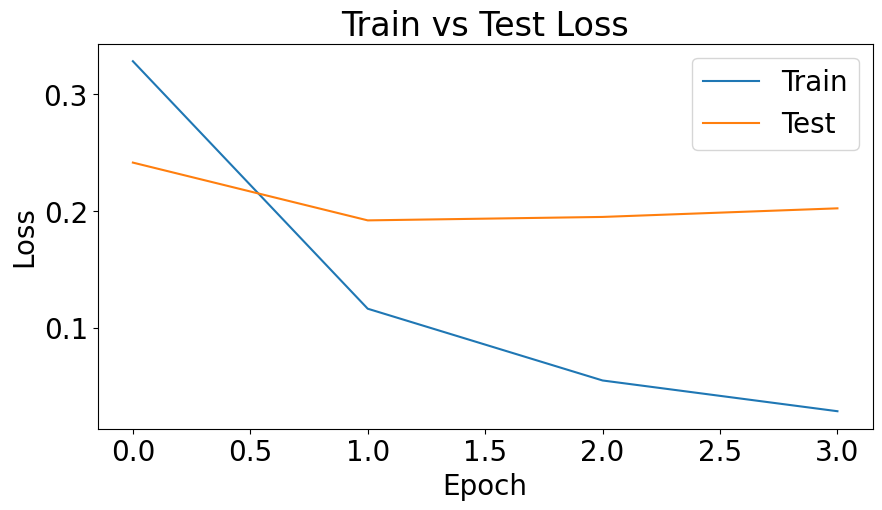

Recall: 0.7191011235955056
[[4702  262]
 [ 150  384]]
Precision: 0.59
Recall: 0.72
F1 Score: 0.65


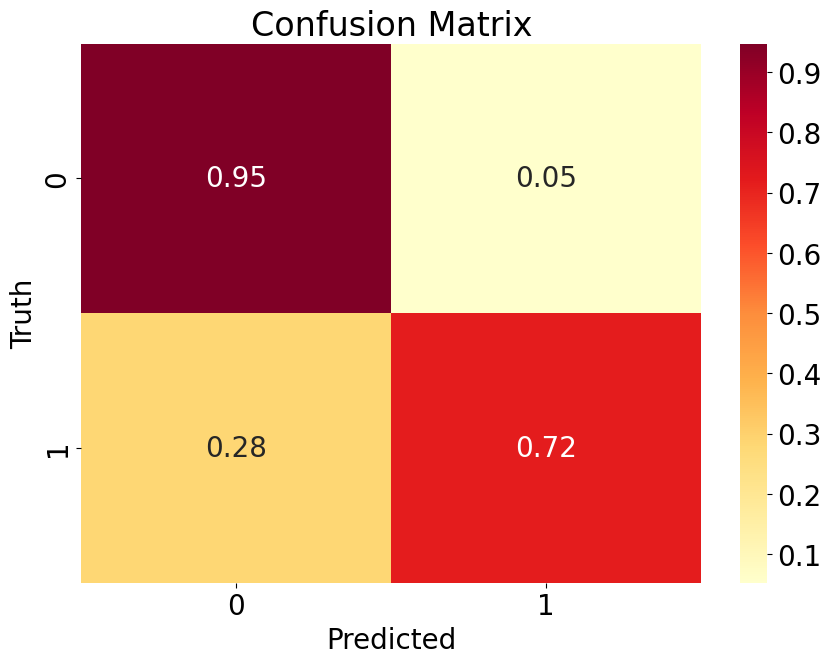

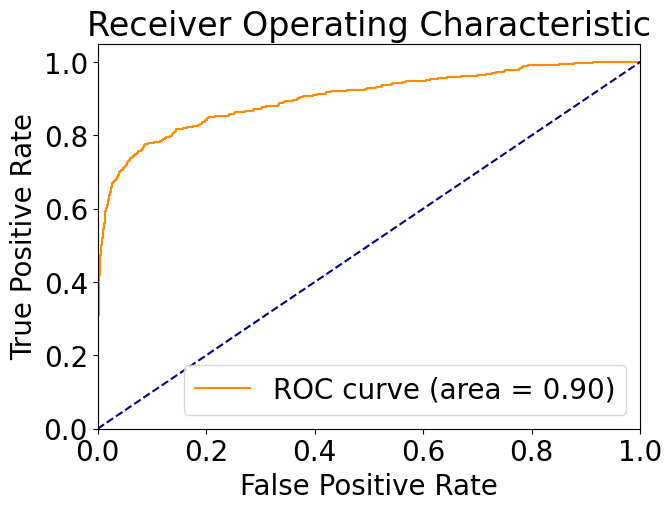

In [167]:
def run_MLP(X_train, X_test, y_train, y_test, 
            batch_size, learning_rate, weight_decay, num_train_epochs):
    # Apply SMOTE to generate synthetic samples
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # create the MLP model
    model = MLPClassifier(hidden_layer_sizes=(256, 32),
                          activation='relu',
                          solver='adam',
                          alpha=weight_decay,
                          batch_size=batch_size,
                          learning_rate='constant',
                          learning_rate_init=learning_rate,
                          power_t=0.5,
                          max_iter=num_train_epochs,  # train for num_train_epochs at a time
                          shuffle=True,
                          random_state=42,
                          tol=1e-7,  # disable early stopping
                          verbose=False, # not print progress messages
                          validation_fraction=0.1,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=1e-8,
                          n_iter_no_change=10,
                          max_fun=15000)

    train_losses = []
    validation_losses = []
    for _ in range(num_train_epochs):
        # Fit the model for one epoch
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))

        # Get the training loss
        train_loss = model.loss_
        train_losses.append(train_loss)

        # Calculate the validation loss
        validation_proba = model.predict_proba(X_test)
        validation_loss = log_loss(y_test, validation_proba)
        validation_losses.append(validation_loss)
        
        print('train_loss', round(train_loss,3), 'validation_loss', round(validation_loss,3))

    return model, train_losses, validation_losses

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Run the MLP model
num_train_epochs = 4
model, train_losses, validation_losses = run_MLP(
    X_train, X_test, y_train, y_test, batch_size=100, 
    learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_train_epochs), train_losses, label='Train')
plt.plot(range(num_train_epochs), validation_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Test Loss')
plt.show()

# Predict probabilities for the test data
probs = model.predict_proba(X_test)

# Change the threshold
threshold = 0.2
y_pred = np.where(probs[:,1] > threshold, 1, 0)

# Compute recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Calculate confusion matrix
#y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(cm)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# one-time AUC and cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

# Set global font size
plt.rcParams.update({'font.size': 20})

# Normalize the confusion matrix
cm_normalized = normalize(cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

5-fold

train_loss 0.751 validation_loss 0.537
train_loss 0.278 validation_loss 0.354
train_loss 0.139 validation_loss 0.349
train_loss 0.093 validation_loss 0.354
train_loss 0.056 validation_loss 0.384
train_loss 0.05 validation_loss 0.426
train_loss 0.043 validation_loss 0.444
train_loss 0.043 validation_loss 0.475
train_loss 0.039 validation_loss 0.451
train_loss 0.044 validation_loss 0.49
train_loss 0.032 validation_loss 0.517
train_loss 0.026 validation_loss 0.531
train_loss 0.028 validation_loss 0.528
train_loss 0.028 validation_loss 0.545
train_loss 0.019 validation_loss 0.52


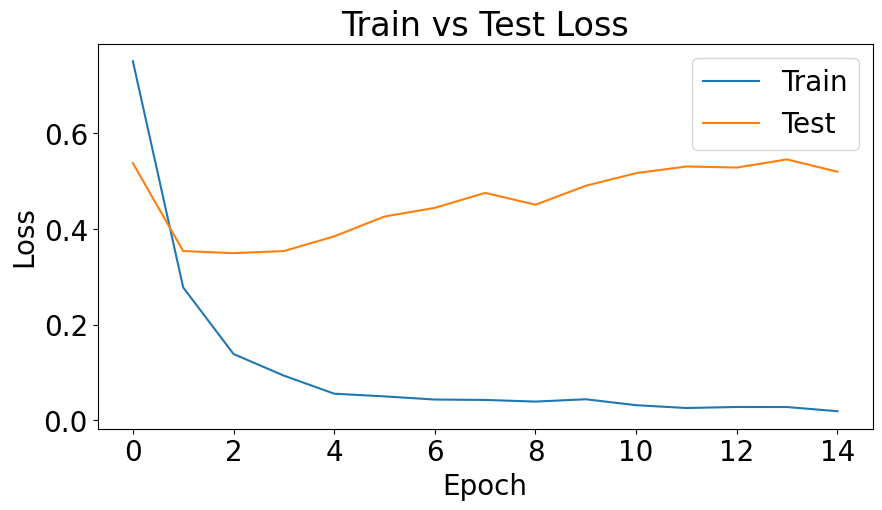

train_loss 0.685 validation_loss 0.521
train_loss 0.256 validation_loss 0.333
train_loss 0.129 validation_loss 0.365
train_loss 0.079 validation_loss 0.368
train_loss 0.064 validation_loss 0.388
train_loss 0.057 validation_loss 0.422
train_loss 0.038 validation_loss 0.465
train_loss 0.031 validation_loss 0.48
train_loss 0.035 validation_loss 0.518
train_loss 0.031 validation_loss 0.51
train_loss 0.038 validation_loss 0.495
train_loss 0.031 validation_loss 0.514
train_loss 0.019 validation_loss 0.563
train_loss 0.024 validation_loss 0.573
train_loss 0.025 validation_loss 0.548


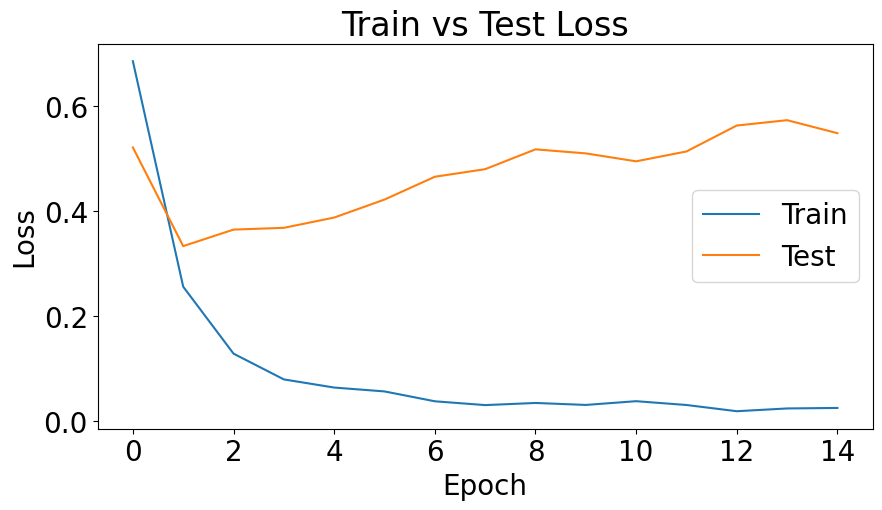

train_loss 0.73 validation_loss 0.54
train_loss 0.242 validation_loss 0.315
train_loss 0.119 validation_loss 0.297
train_loss 0.075 validation_loss 0.337
train_loss 0.054 validation_loss 0.34
train_loss 0.044 validation_loss 0.346
train_loss 0.049 validation_loss 0.398
train_loss 0.056 validation_loss 0.399
train_loss 0.038 validation_loss 0.443
train_loss 0.024 validation_loss 0.425
train_loss 0.027 validation_loss 0.441
train_loss 0.034 validation_loss 0.431
train_loss 0.031 validation_loss 0.448
train_loss 0.02 validation_loss 0.478
train_loss 0.023 validation_loss 0.476


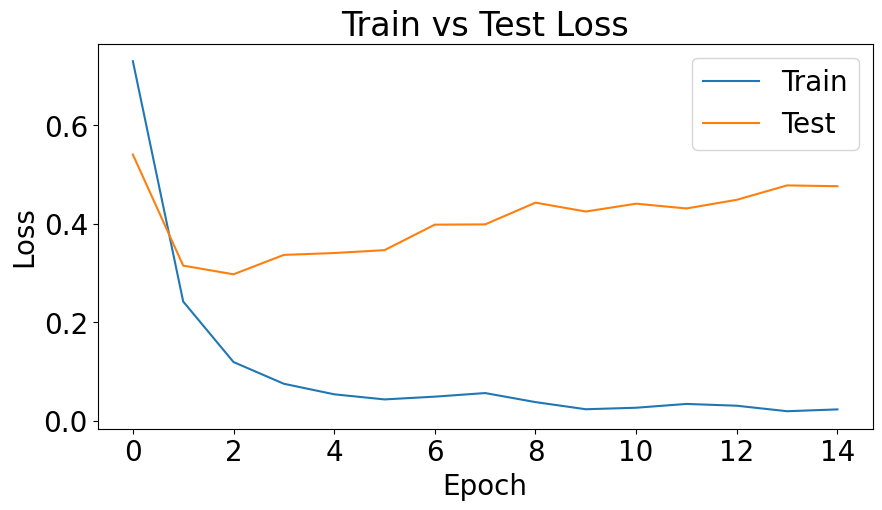

train_loss 0.76 validation_loss 0.402
train_loss 0.227 validation_loss 0.341
train_loss 0.117 validation_loss 0.323
train_loss 0.076 validation_loss 0.345
train_loss 0.053 validation_loss 0.362
train_loss 0.045 validation_loss 0.399
train_loss 0.047 validation_loss 0.416
train_loss 0.037 validation_loss 0.443
train_loss 0.033 validation_loss 0.444
train_loss 0.029 validation_loss 0.462
train_loss 0.032 validation_loss 0.454
train_loss 0.021 validation_loss 0.478
train_loss 0.03 validation_loss 0.492
train_loss 0.022 validation_loss 0.48
train_loss 0.025 validation_loss 0.482


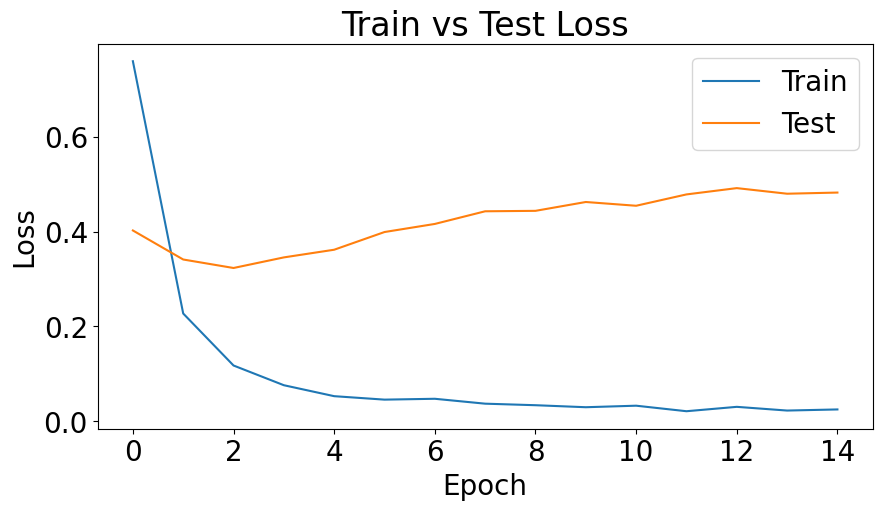

train_loss 0.728 validation_loss 0.523
train_loss 0.242 validation_loss 0.375
train_loss 0.126 validation_loss 0.404
train_loss 0.083 validation_loss 0.442
train_loss 0.055 validation_loss 0.507
train_loss 0.054 validation_loss 0.466
train_loss 0.056 validation_loss 0.498
train_loss 0.037 validation_loss 0.496
train_loss 0.028 validation_loss 0.511
train_loss 0.025 validation_loss 0.608
train_loss 0.038 validation_loss 0.548
train_loss 0.04 validation_loss 0.565
train_loss 0.033 validation_loss 0.627
train_loss 0.021 validation_loss 0.588
train_loss 0.02 validation_loss 0.563


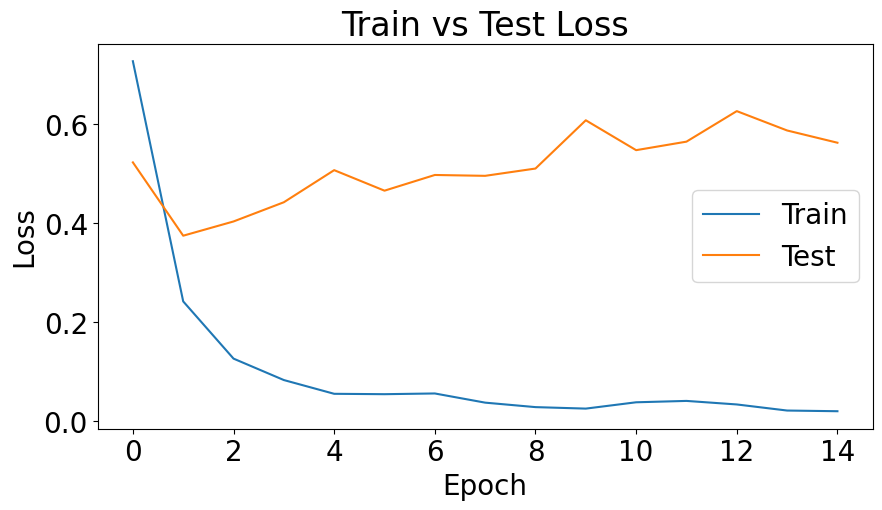

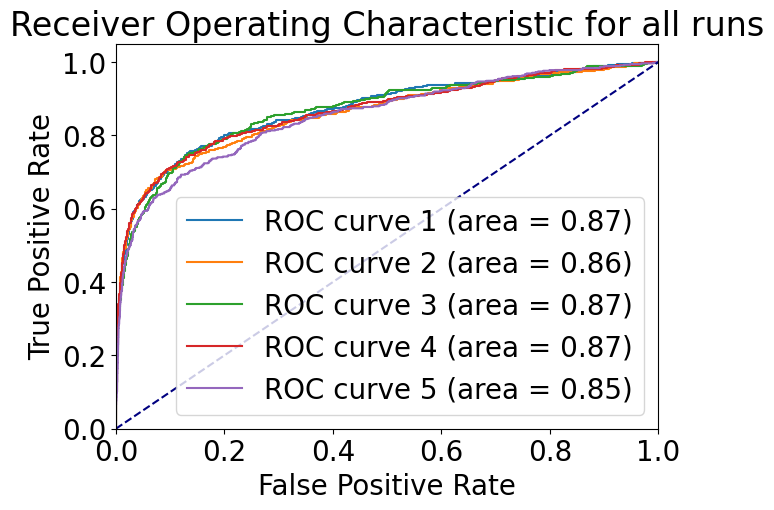

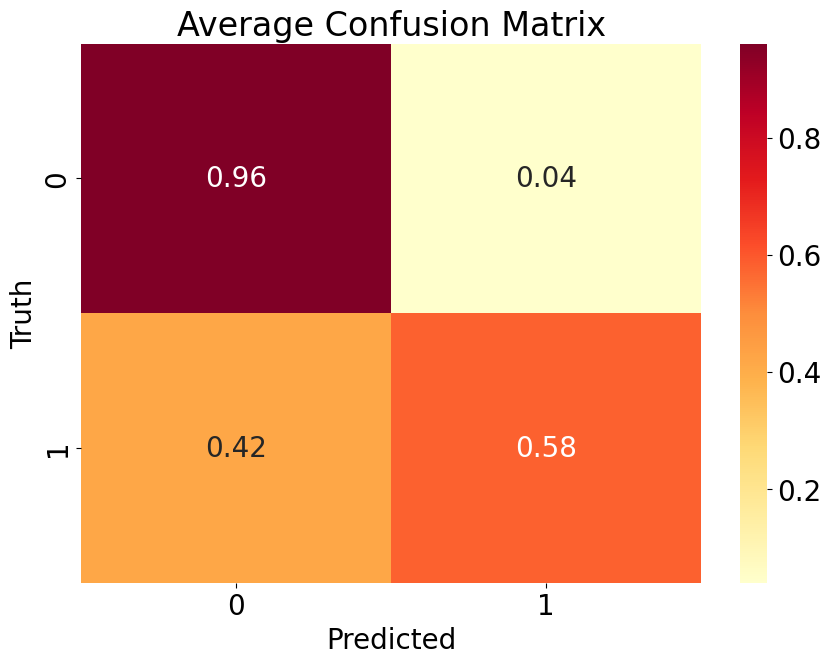

In [87]:
import random
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)

    # Run the MLP model
    num_train_epochs = 15
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)

# Plot all AUCs
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()

#### Features Ablation

100%|████████████████████████████████████████████████████| 24740/24740 [00:00<00:00, 51059.11it/s]


27489
train_loss 0.427 validation_loss 0.339
train_loss 0.219 validation_loss 0.264
train_loss 0.131 validation_loss 0.233
train_loss 0.083 validation_loss 0.224


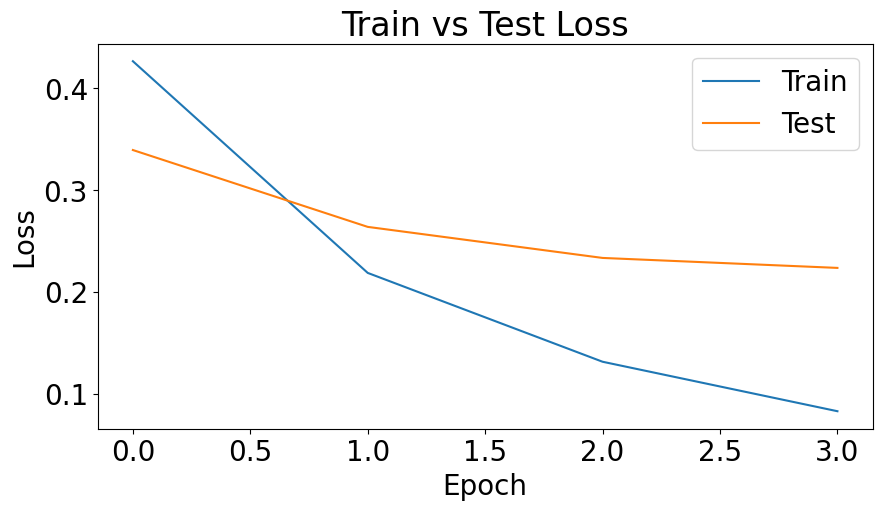

train_loss 0.427 validation_loss 0.35
train_loss 0.219 validation_loss 0.267
train_loss 0.133 validation_loss 0.238
train_loss 0.083 validation_loss 0.233


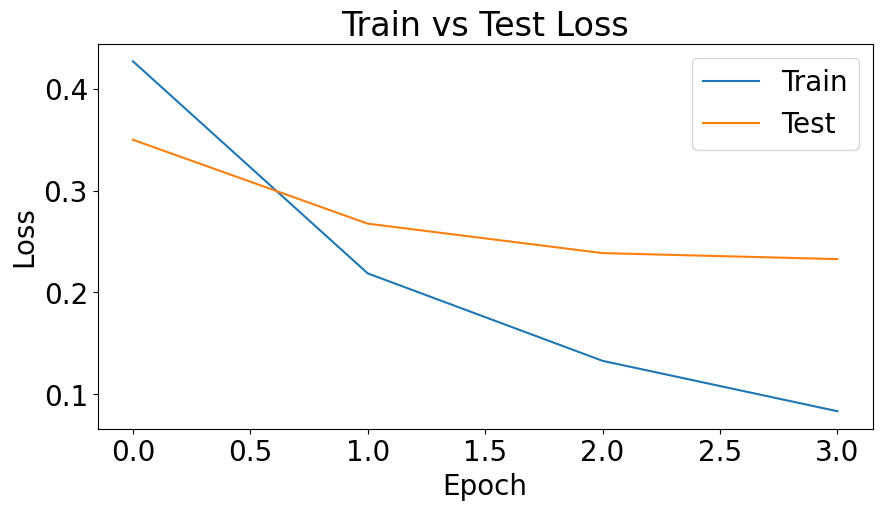

train_loss 0.421 validation_loss 0.345
train_loss 0.211 validation_loss 0.269
train_loss 0.125 validation_loss 0.248
train_loss 0.077 validation_loss 0.248


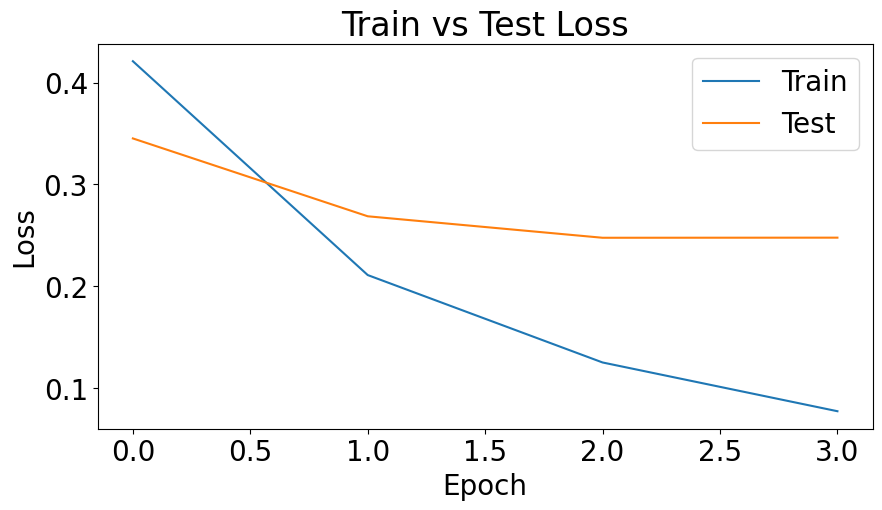

train_loss 0.431 validation_loss 0.334
train_loss 0.217 validation_loss 0.258
train_loss 0.129 validation_loss 0.232
train_loss 0.08 validation_loss 0.224


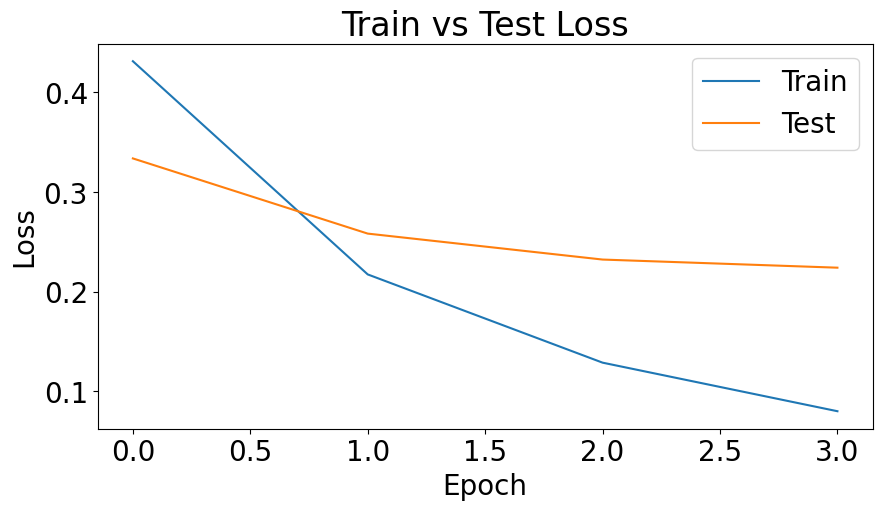

train_loss 0.428 validation_loss 0.311
train_loss 0.215 validation_loss 0.262
train_loss 0.128 validation_loss 0.24
train_loss 0.08 validation_loss 0.232


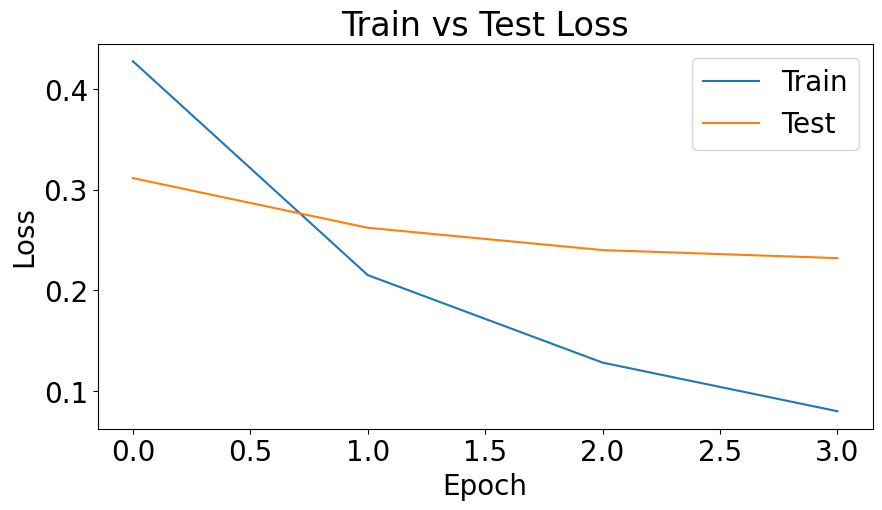

[array([[4440,  525],
       [ 149,  383]]), array([[4412,  565],
       [ 149,  371]]), array([[4457,  426],
       [ 193,  421]]), array([[4420,  527],
       [ 149,  401]]), array([[4402,  563],
       [ 156,  376]])]


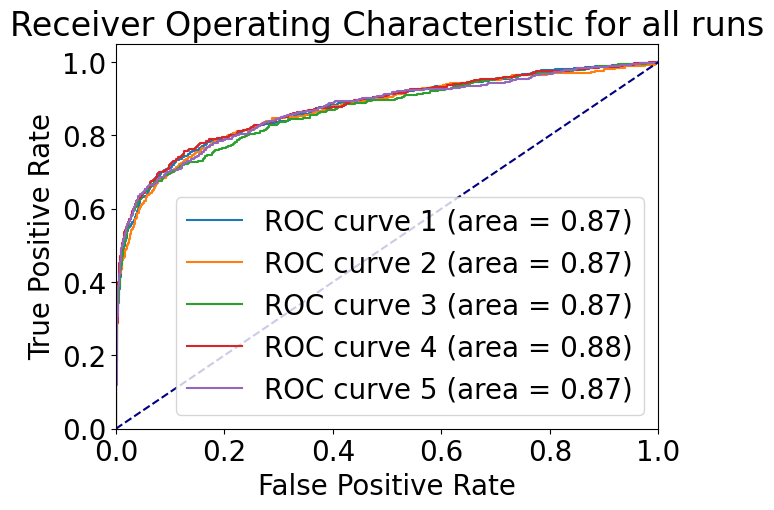

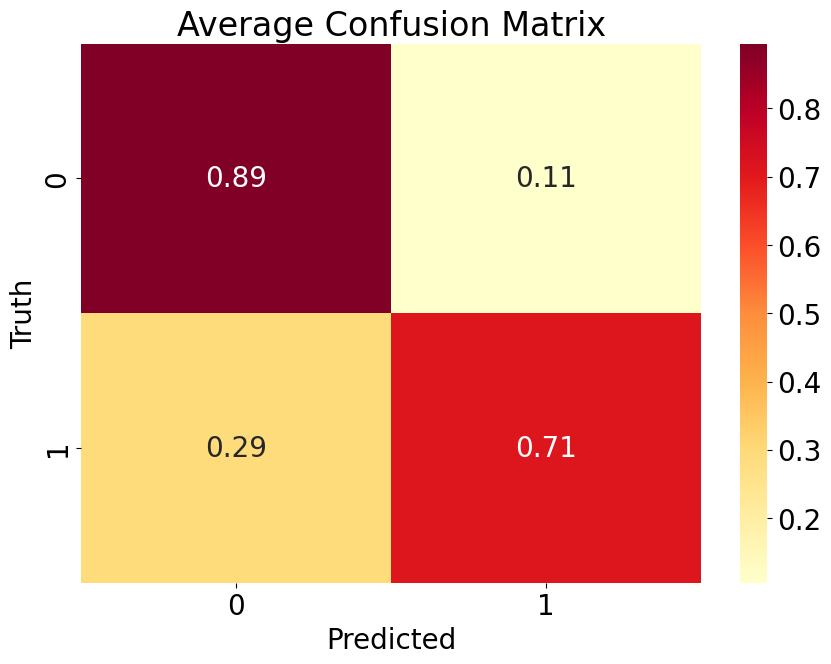

In [177]:
# D 
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)
    
    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)

print(cms)
    
# Plot all AUCs
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        


D \
DNA AUC 0.872 \
pre 0.430 \
recall 0.711

100%|████████████████████████████████████████████████████| 24740/24740 [00:00<00:00, 71009.73it/s]


27489
train_loss 0.381 validation_loss 0.303
train_loss 0.184 validation_loss 0.229
train_loss 0.108 validation_loss 0.212
train_loss 0.065 validation_loss 0.209


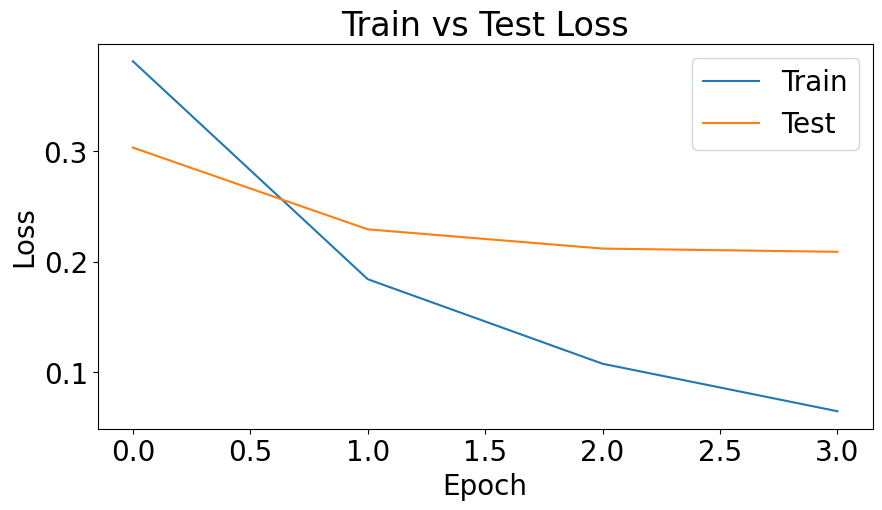

train_loss 0.384 validation_loss 0.311
train_loss 0.185 validation_loss 0.24
train_loss 0.107 validation_loss 0.214
train_loss 0.064 validation_loss 0.208


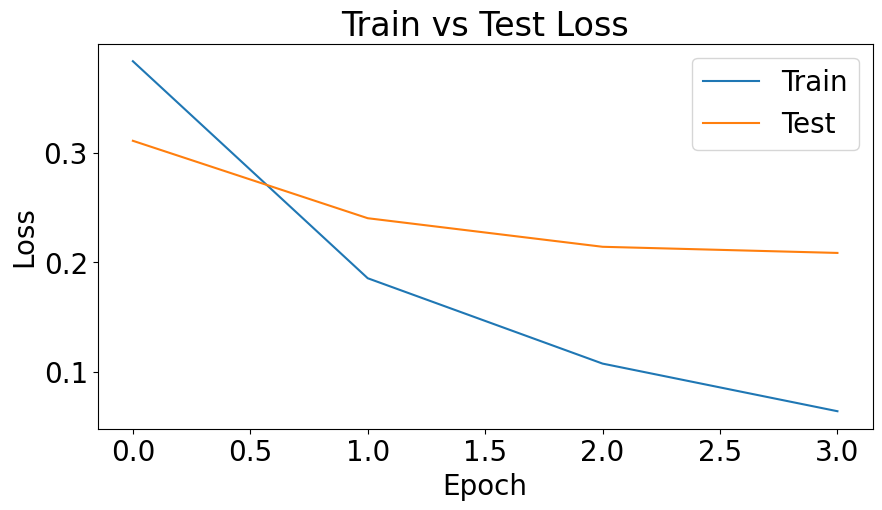

train_loss 0.386 validation_loss 0.291
train_loss 0.188 validation_loss 0.224
train_loss 0.11 validation_loss 0.206
train_loss 0.067 validation_loss 0.205


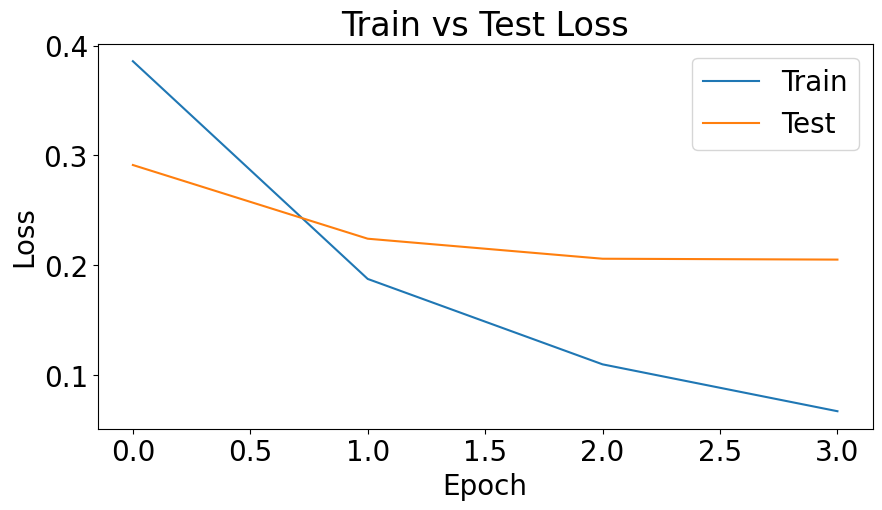

train_loss 0.38 validation_loss 0.301
train_loss 0.184 validation_loss 0.244
train_loss 0.107 validation_loss 0.221
train_loss 0.064 validation_loss 0.218


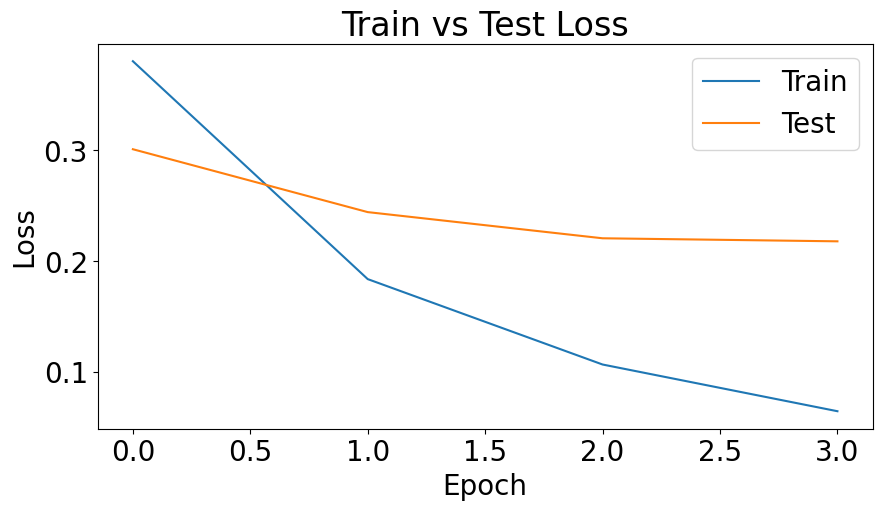

train_loss 0.384 validation_loss 0.307
train_loss 0.185 validation_loss 0.232
train_loss 0.108 validation_loss 0.211
train_loss 0.065 validation_loss 0.208


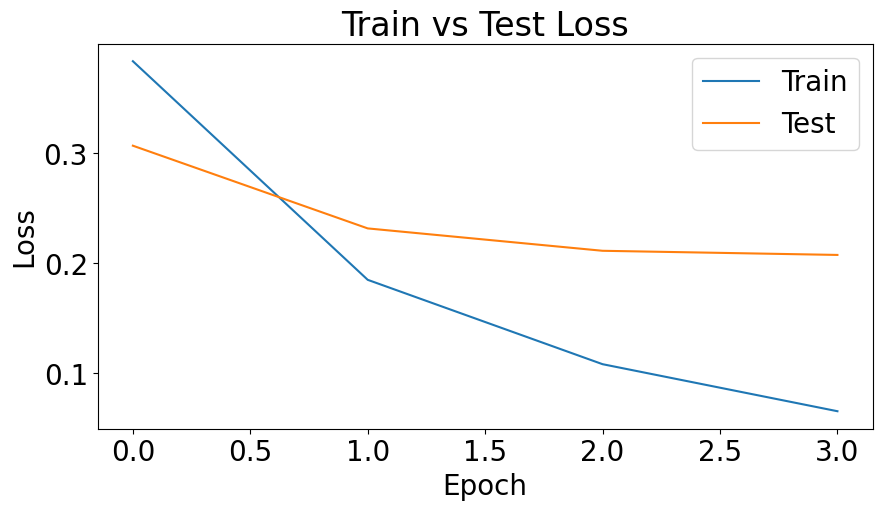

[array([[4461,  473],
       [ 143,  420]]), array([[4496,  457],
       [ 142,  402]]), array([[4564,  417],
       [ 139,  377]]), array([[4455,  481],
       [ 164,  397]]), array([[4521,  411],
       [ 144,  421]])]


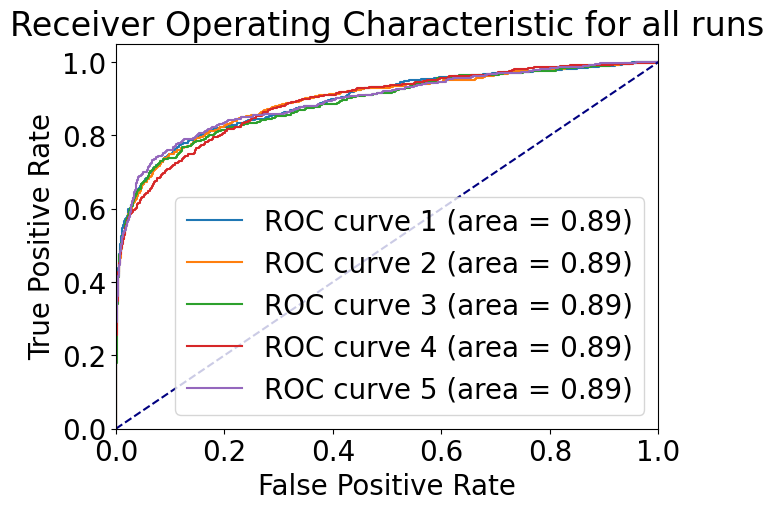

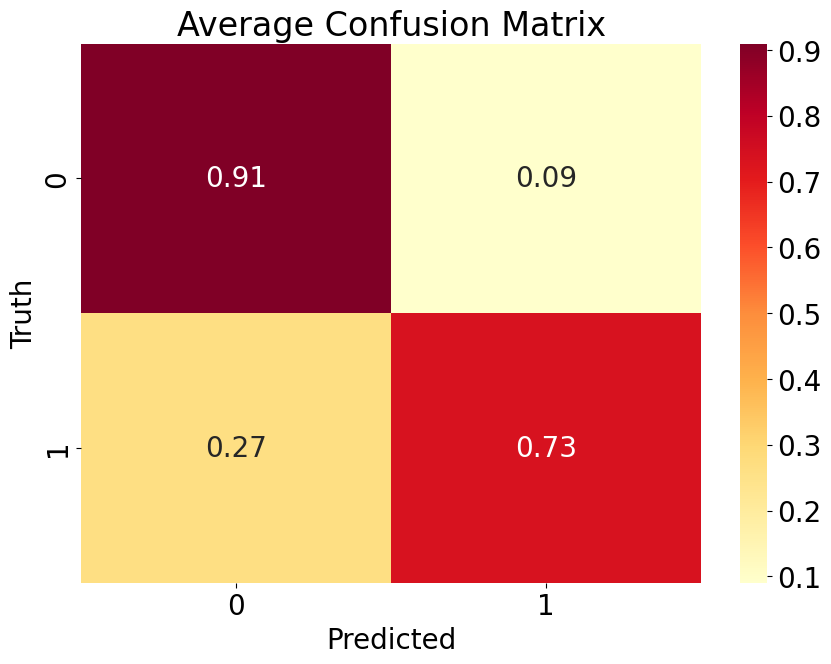

In [178]:
# P 0.890
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([c,d]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([c,d]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)
    
    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)

print(cms)
    
# Plot all AUCs
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        

P \
0.890\
0.469\
0.708

100%|█████████████████████████████████████████████████████| 24740/24740 [00:05<00:00, 4874.56it/s]


27489
train_loss 0.397 validation_loss 0.321
train_loss 0.163 validation_loss 0.241
train_loss 0.089 validation_loss 0.23
train_loss 0.055 validation_loss 0.237


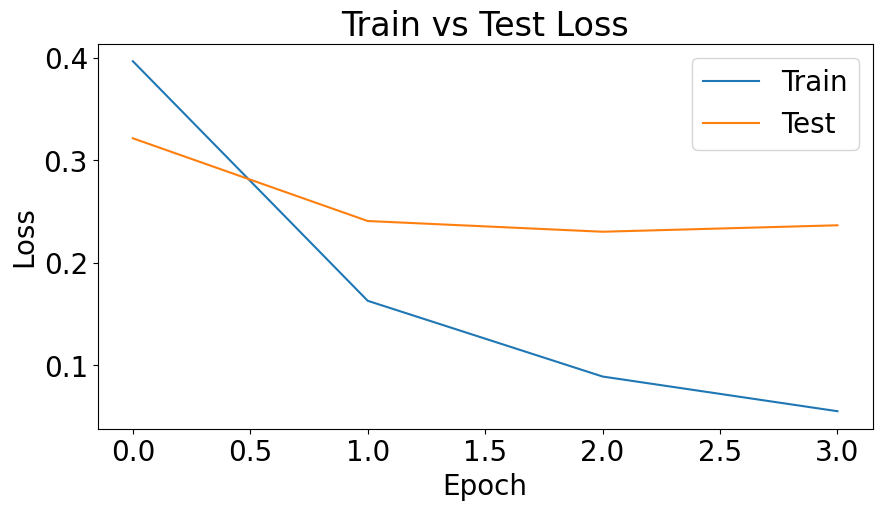

train_loss 0.392 validation_loss 0.281
train_loss 0.158 validation_loss 0.246
train_loss 0.085 validation_loss 0.236
train_loss 0.052 validation_loss 0.24


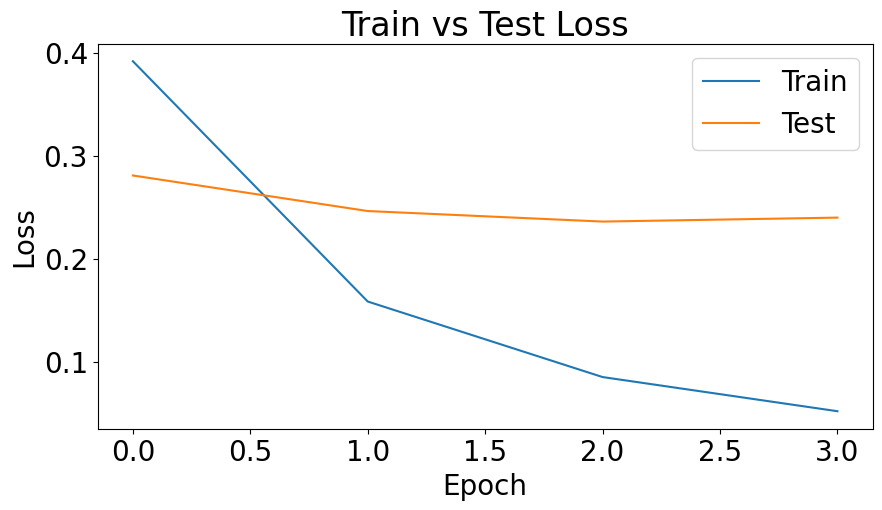

train_loss 0.393 validation_loss 0.281
train_loss 0.16 validation_loss 0.223
train_loss 0.088 validation_loss 0.22
train_loss 0.055 validation_loss 0.231


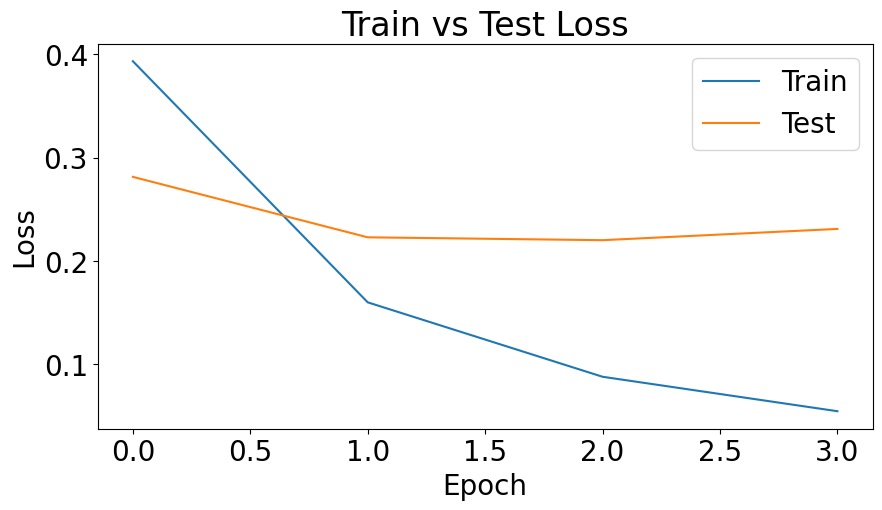

train_loss 0.389 validation_loss 0.296
train_loss 0.157 validation_loss 0.235
train_loss 0.086 validation_loss 0.236
train_loss 0.053 validation_loss 0.246


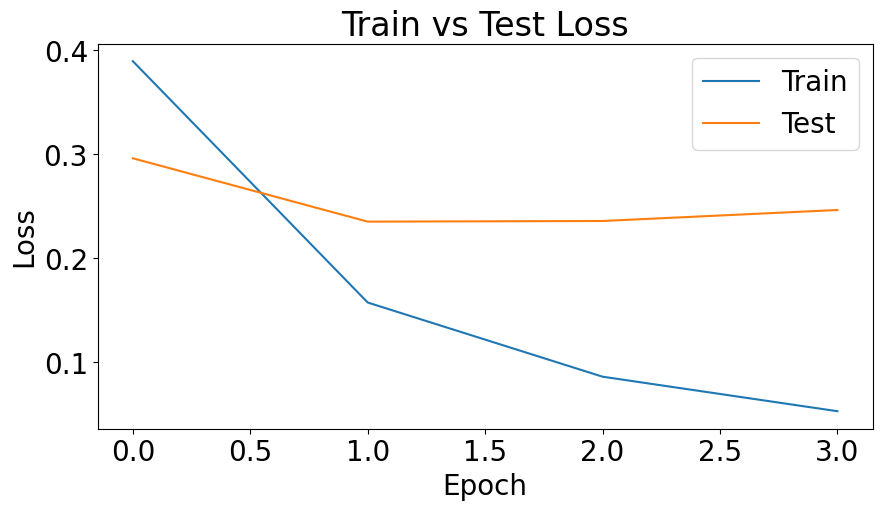

train_loss 0.393 validation_loss 0.282
train_loss 0.16 validation_loss 0.205
train_loss 0.086 validation_loss 0.203
train_loss 0.052 validation_loss 0.216


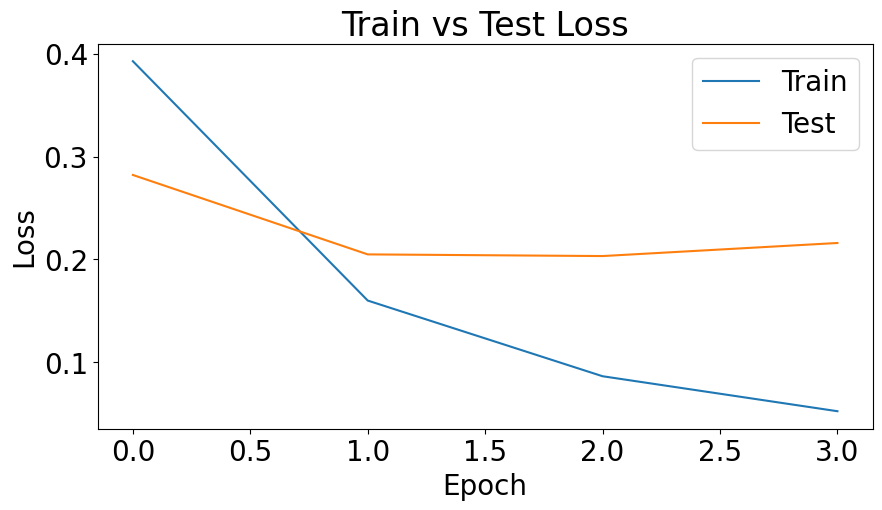

[array([[4587,  362],
       [ 171,  377]]), array([[4514,  430],
       [ 152,  401]]), array([[4525,  410],
       [ 160,  402]]), array([[4515,  432],
       [ 153,  397]]), array([[4650,  312],
       [ 166,  369]])]


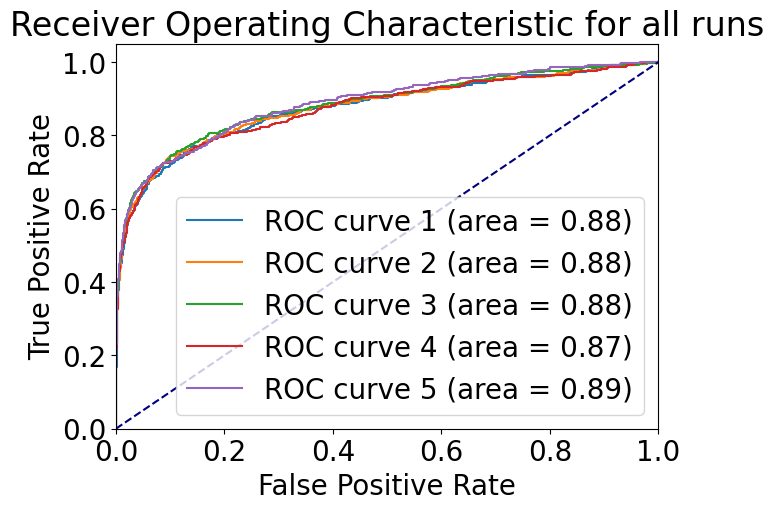

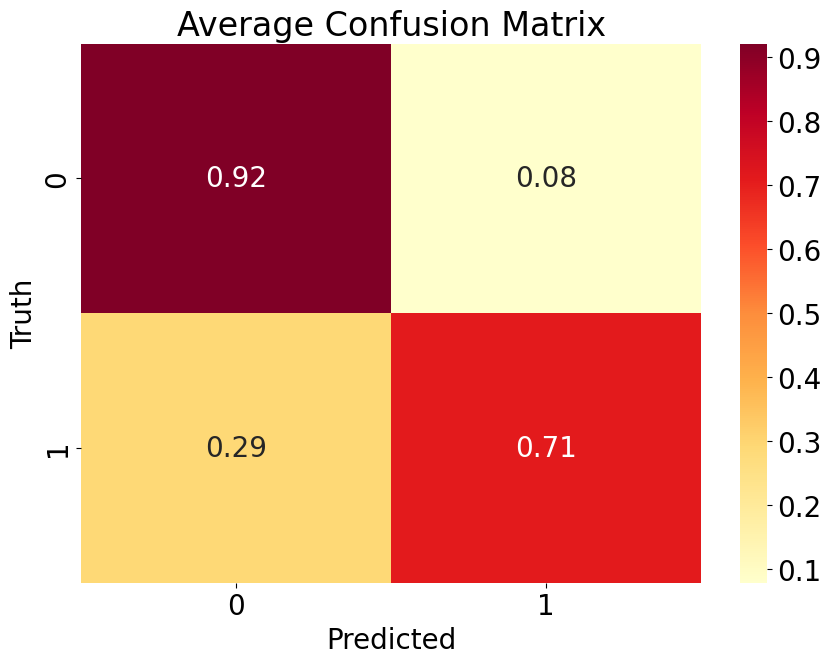

In [183]:
# S
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)
    
    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)

# Plot all AUCs
print(cms)
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        

S\
0.880\
0.478\
0.617

100%|████████████████████████████████████████████████████| 24740/24740 [00:00<00:00, 32658.84it/s]


27489
train_loss 0.326 validation_loss 0.264
train_loss 0.114 validation_loss 0.216
train_loss 0.053 validation_loss 0.219
train_loss 0.028 validation_loss 0.23


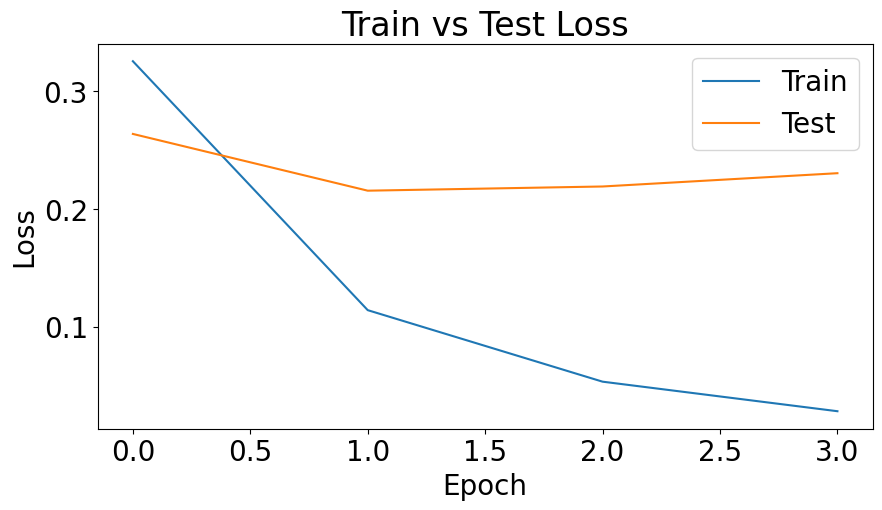

train_loss 0.328 validation_loss 0.242
train_loss 0.115 validation_loss 0.199
train_loss 0.053 validation_loss 0.193
train_loss 0.027 validation_loss 0.203


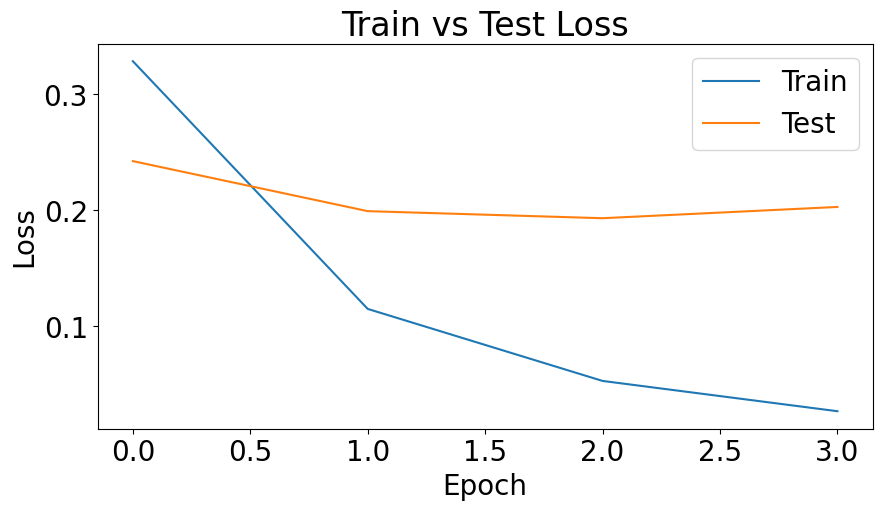

train_loss 0.333 validation_loss 0.23
train_loss 0.117 validation_loss 0.198
train_loss 0.054 validation_loss 0.196
train_loss 0.028 validation_loss 0.208


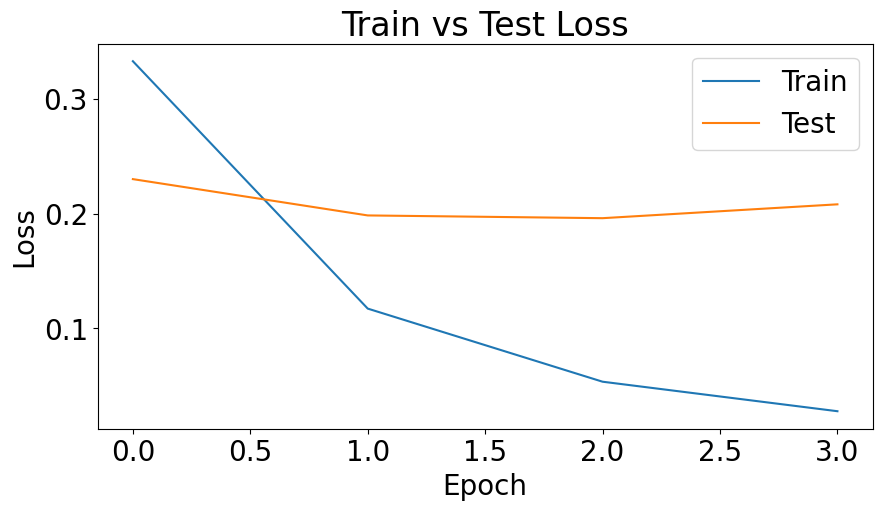

train_loss 0.331 validation_loss 0.247
train_loss 0.116 validation_loss 0.195
train_loss 0.054 validation_loss 0.192
train_loss 0.028 validation_loss 0.2


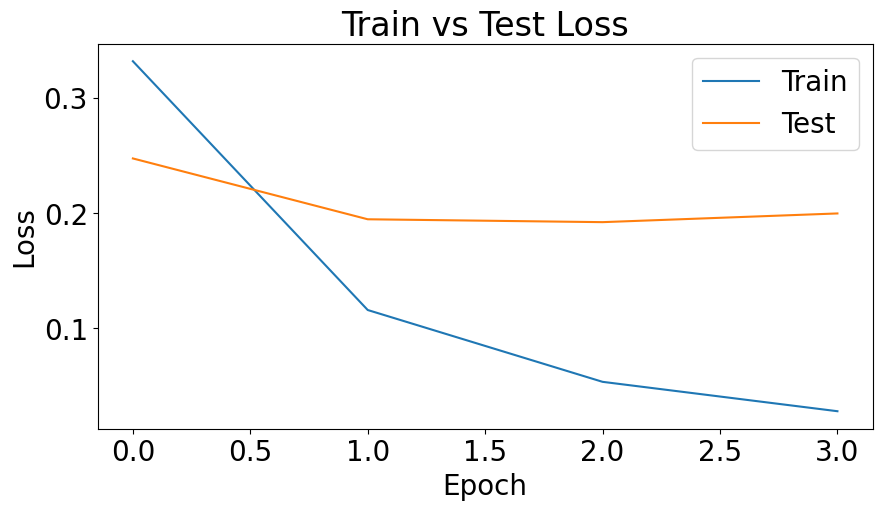

train_loss 0.334 validation_loss 0.243
train_loss 0.117 validation_loss 0.209
train_loss 0.053 validation_loss 0.211
train_loss 0.027 validation_loss 0.225


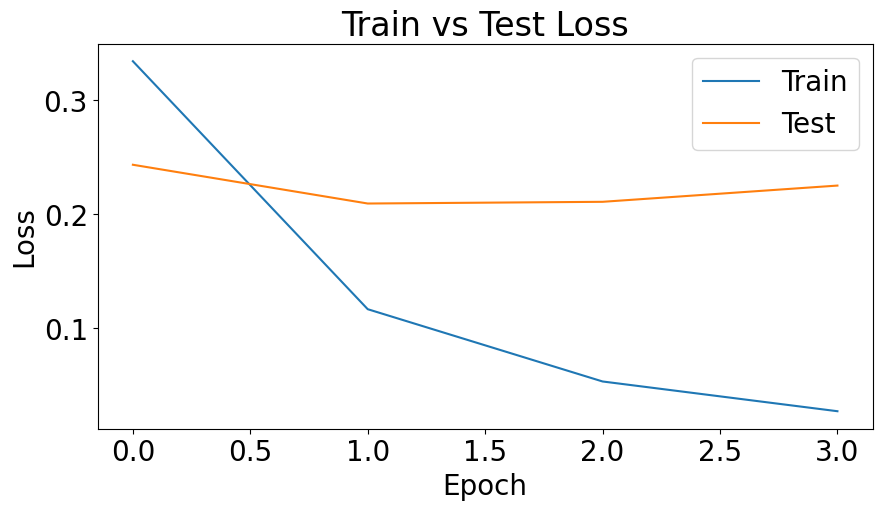

[array([[4685,  263],
       [ 172,  377]]), array([[4684,  251],
       [ 144,  418]]), array([[4622,  327],
       [ 134,  414]]), array([[4667,  284],
       [ 142,  404]]), array([[4699,  255],
       [ 173,  370]])]


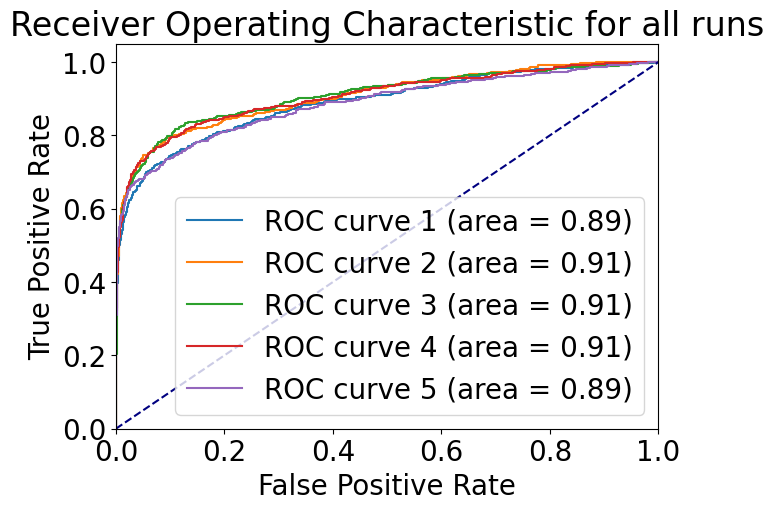

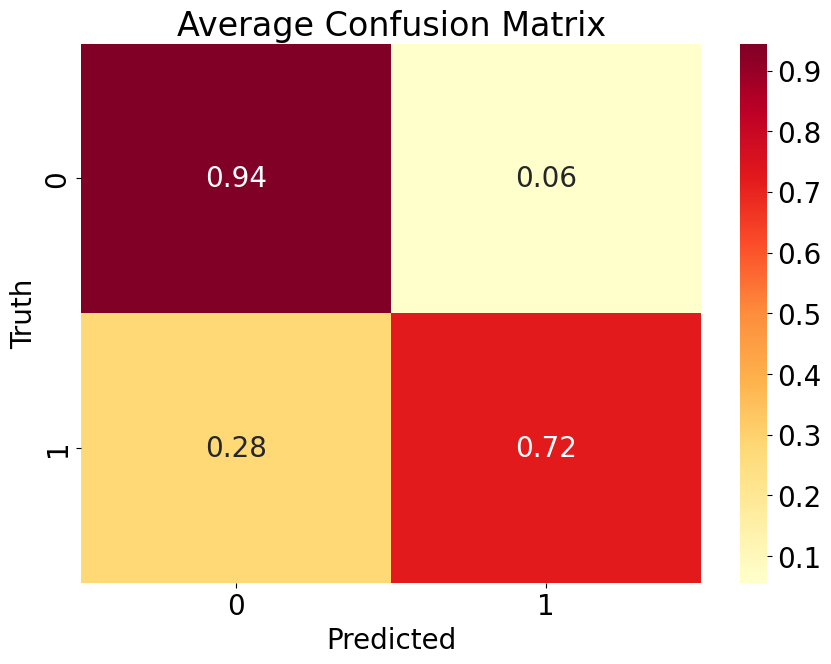

In [179]:
# DP
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)
    
    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)


print(cms)    
    
# Plot all AUCs
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        

DP\
0.902\
0.663\
0.675

100%|█████████████████████████████████████████████████████| 24740/24740 [00:12<00:00, 2057.33it/s]


27489
train_loss 0.301 validation_loss 0.218
train_loss 0.089 validation_loss 0.199
train_loss 0.039 validation_loss 0.214
train_loss 0.02 validation_loss 0.214


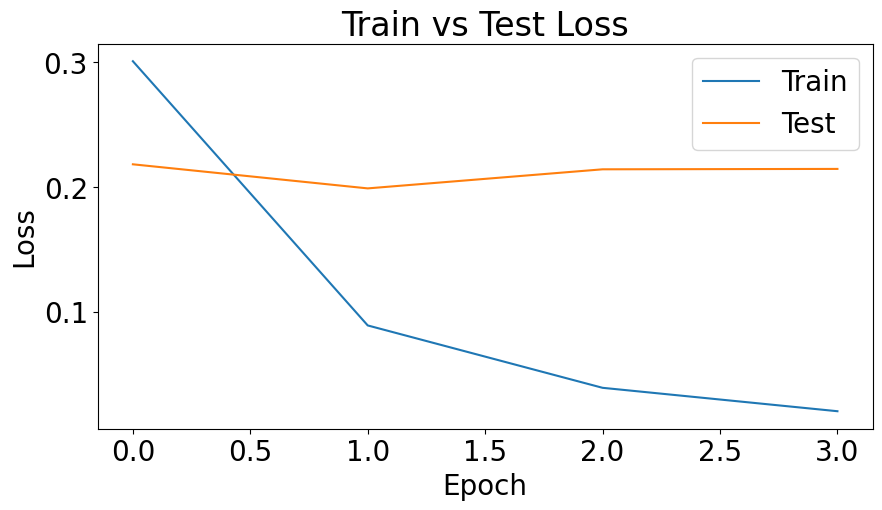

train_loss 0.305 validation_loss 0.222
train_loss 0.089 validation_loss 0.194
train_loss 0.038 validation_loss 0.205
train_loss 0.021 validation_loss 0.22


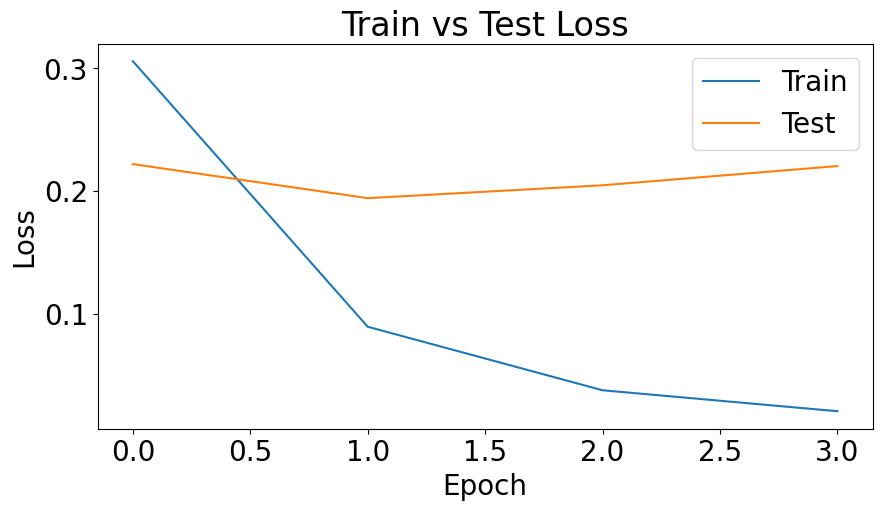

train_loss 0.306 validation_loss 0.227
train_loss 0.092 validation_loss 0.187
train_loss 0.04 validation_loss 0.196
train_loss 0.021 validation_loss 0.206


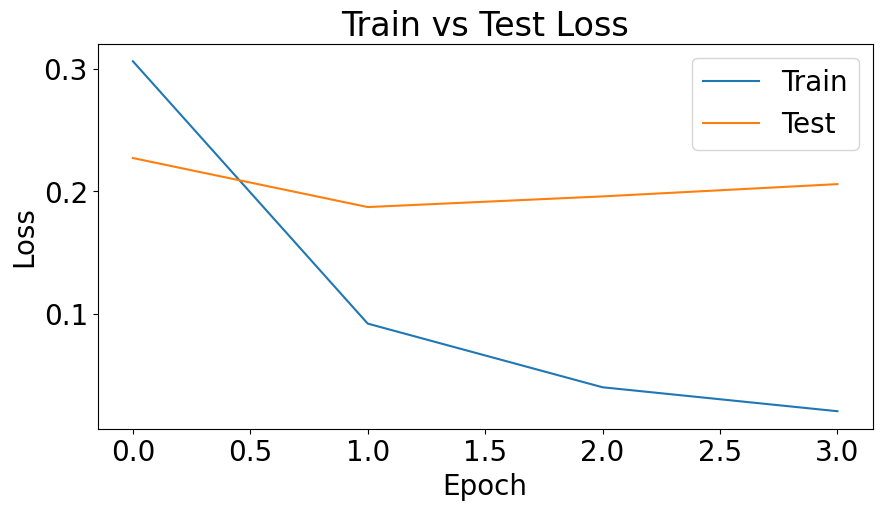

train_loss 0.301 validation_loss 0.226
train_loss 0.089 validation_loss 0.186
train_loss 0.04 validation_loss 0.197
train_loss 0.021 validation_loss 0.211


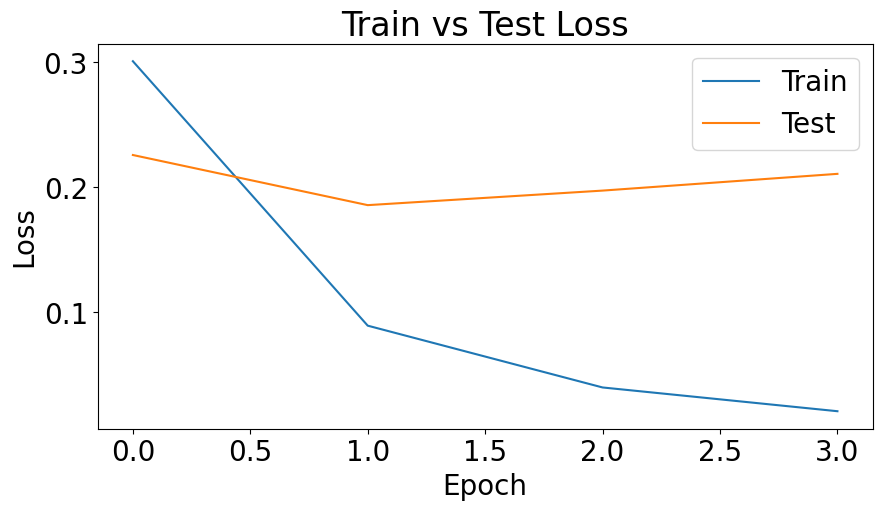

train_loss 0.293 validation_loss 0.228
train_loss 0.086 validation_loss 0.214
train_loss 0.037 validation_loss 0.231
train_loss 0.02 validation_loss 0.246


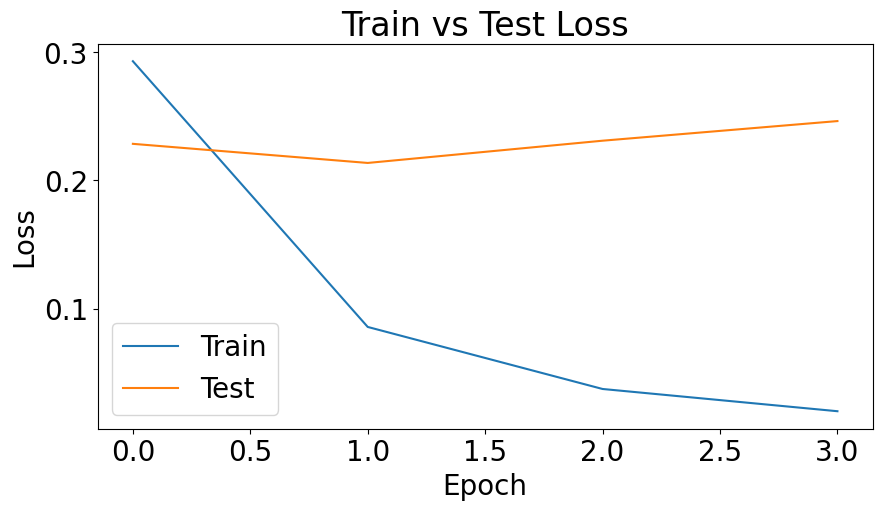

[array([[4705,  255],
       [ 150,  387]]), array([[4697,  261],
       [ 151,  388]]), array([[4670,  268],
       [ 148,  411]]), array([[4750,  215],
       [ 160,  372]]), array([[4657,  258],
       [ 175,  407]])]


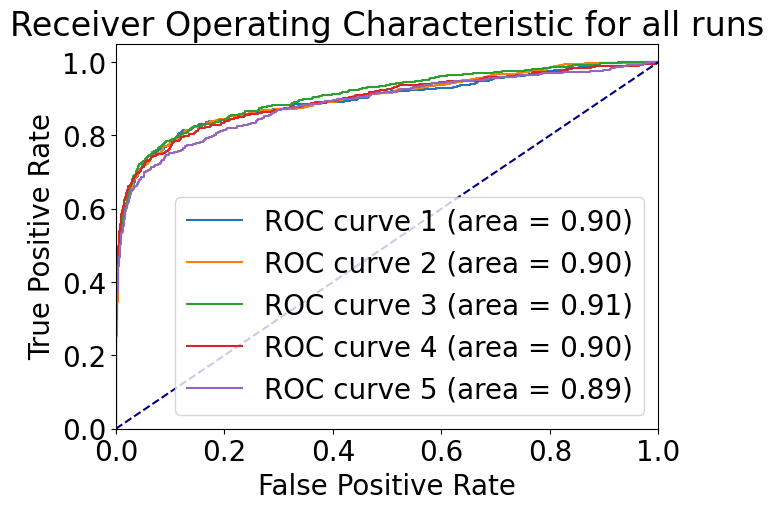

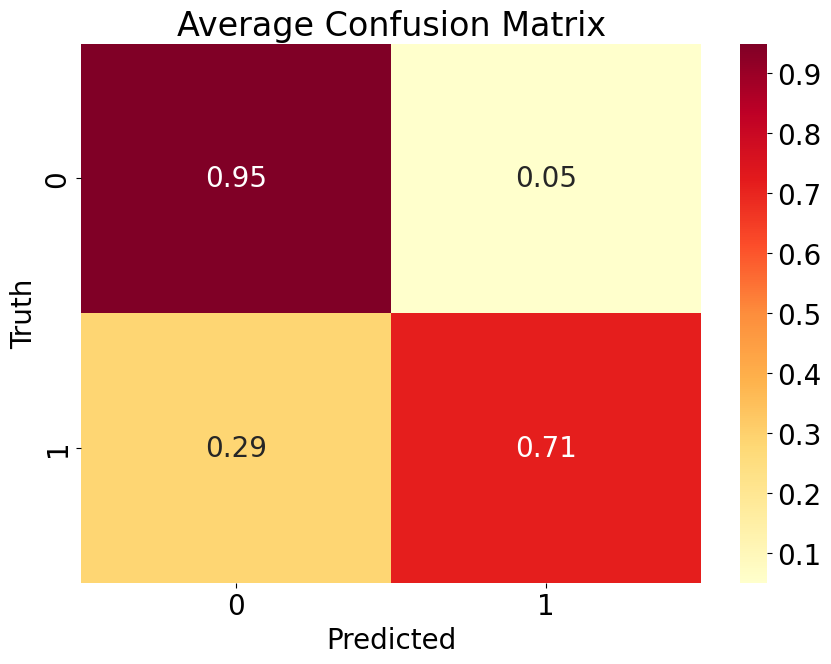

In [180]:
# DS 
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)

    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)


print(cms)
# Plot all AUCs
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        

DS\
0.900\
0.605\
0.627

100%|█████████████████████████████████████████████████████| 24740/24740 [00:04<00:00, 5256.02it/s]


27489
train_loss 0.287 validation_loss 0.195
train_loss 0.076 validation_loss 0.185
train_loss 0.032 validation_loss 0.188
train_loss 0.016 validation_loss 0.197


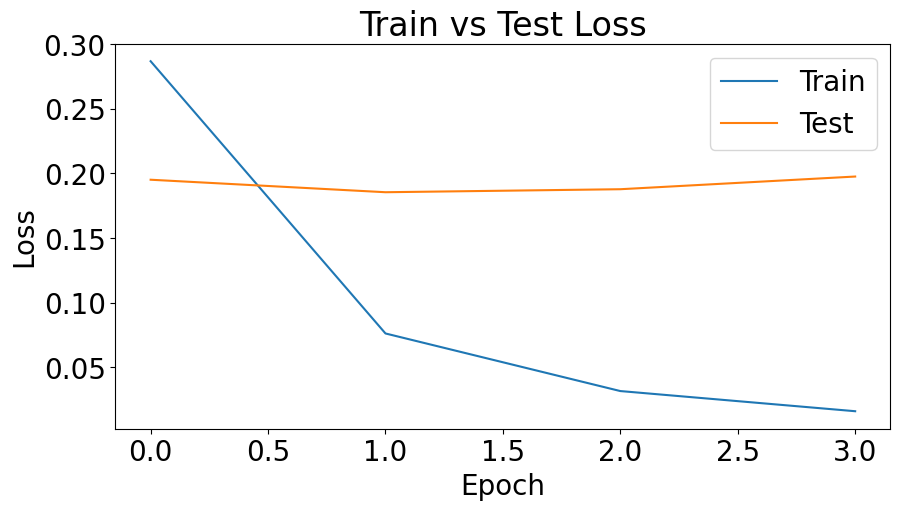

train_loss 0.278 validation_loss 0.21
train_loss 0.078 validation_loss 0.194
train_loss 0.031 validation_loss 0.205
train_loss 0.016 validation_loss 0.214


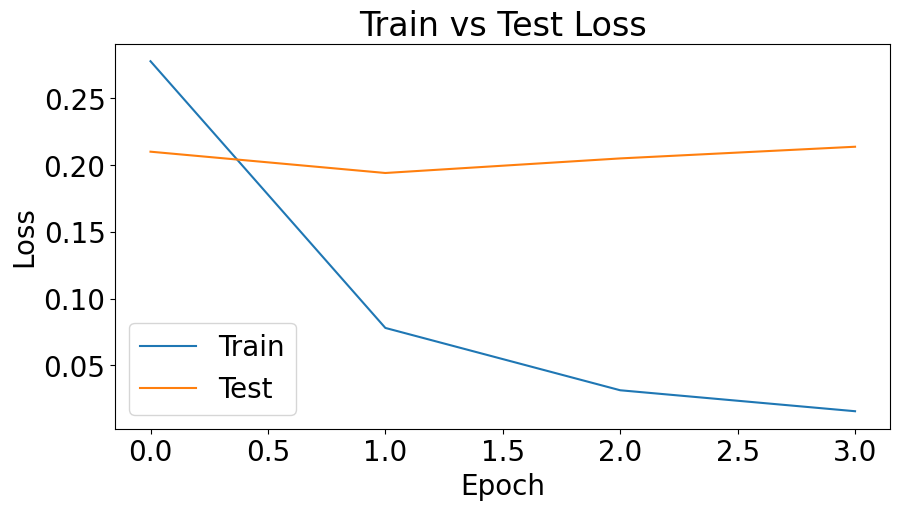

train_loss 0.28 validation_loss 0.217
train_loss 0.073 validation_loss 0.2
train_loss 0.029 validation_loss 0.213
train_loss 0.014 validation_loss 0.223


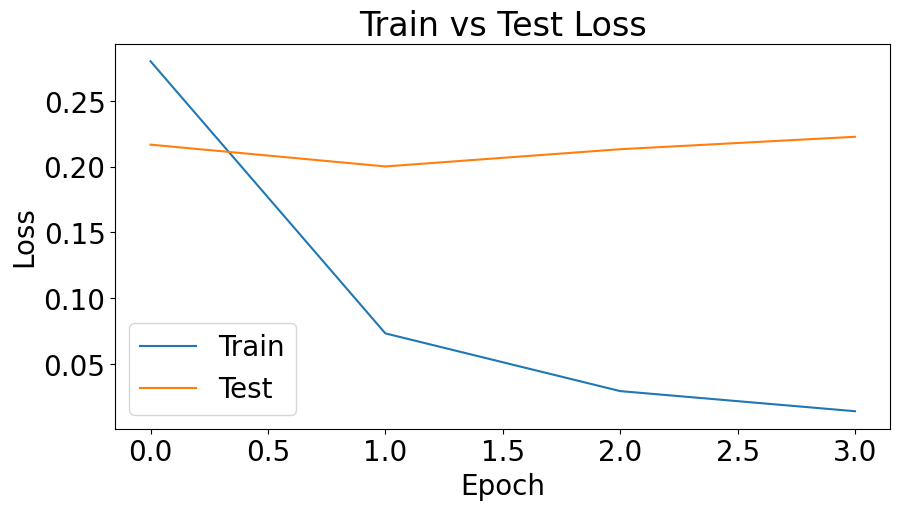

train_loss 0.28 validation_loss 0.214
train_loss 0.073 validation_loss 0.195
train_loss 0.03 validation_loss 0.205
train_loss 0.015 validation_loss 0.219


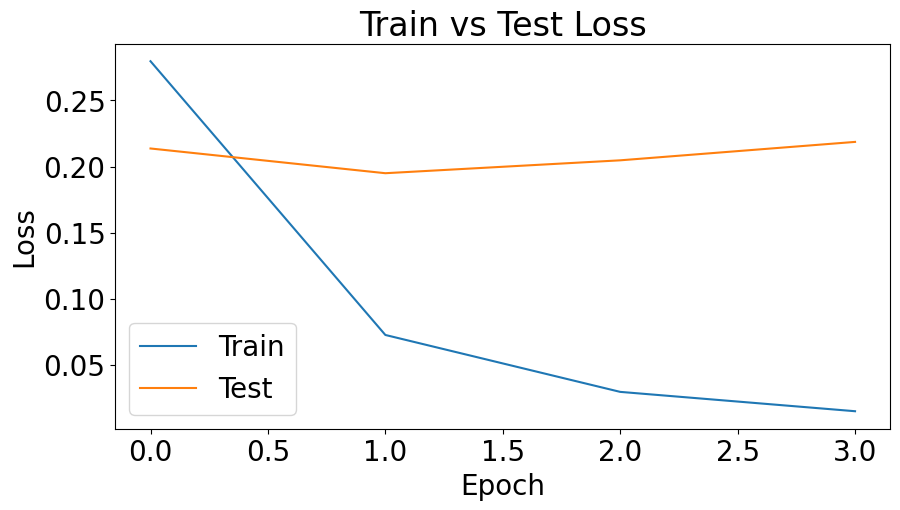

train_loss 0.283 validation_loss 0.202
train_loss 0.074 validation_loss 0.186
train_loss 0.03 validation_loss 0.19
train_loss 0.014 validation_loss 0.198


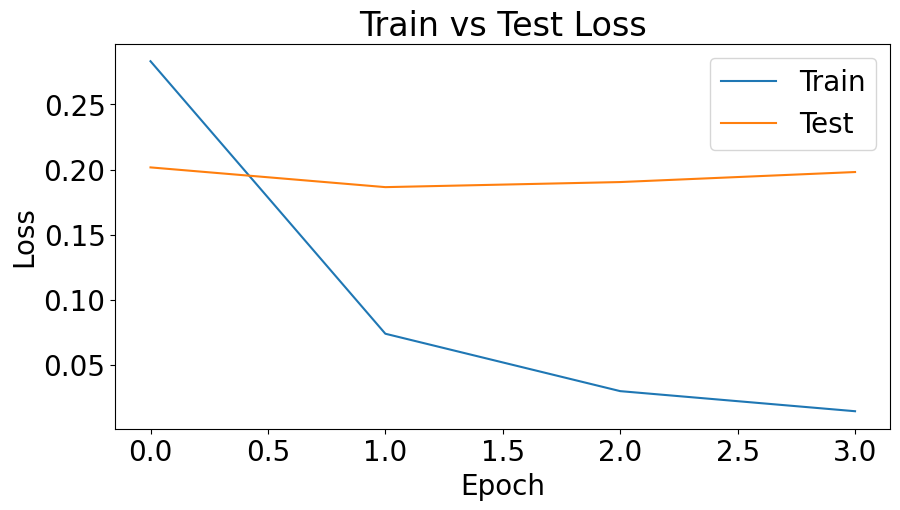

[array([[4721,  239],
       [ 153,  384]]), array([[4680,  255],
       [ 164,  398]]), array([[4725,  228],
       [ 161,  383]]), array([[4675,  250],
       [ 170,  402]]), array([[4724,  239],
       [ 149,  385]])]


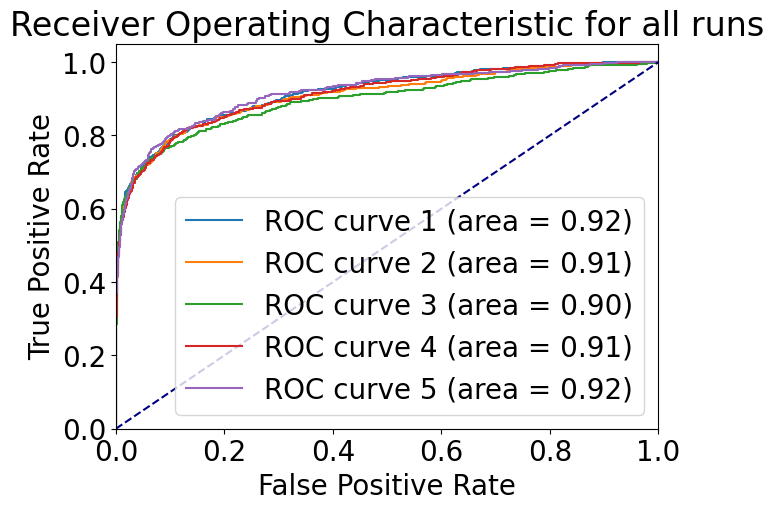

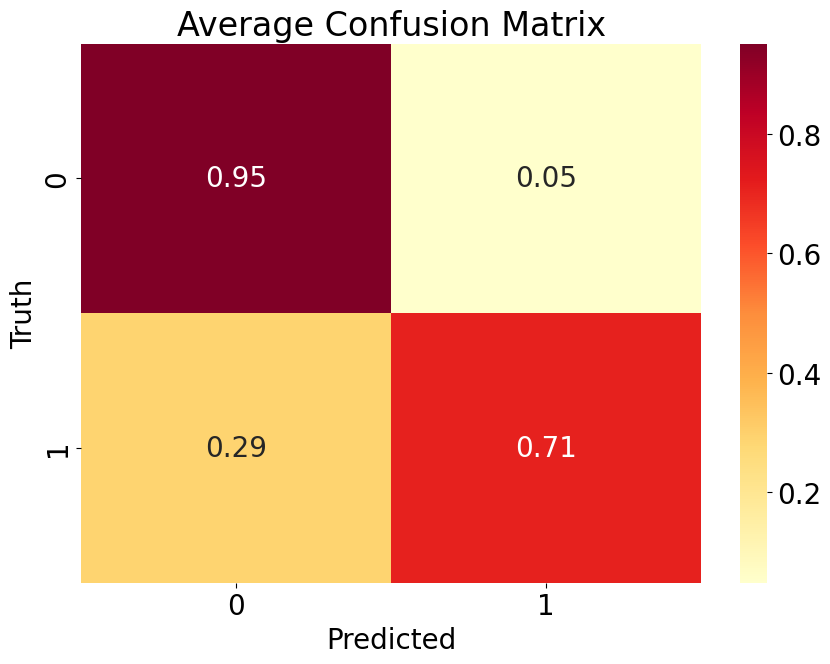

In [182]:
# PS 
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([c,d,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([c,d,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)
    
    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)

# Plot all AUCs
print(cms)
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        

PS\
0.912\
0.611\
0.619

100%|█████████████████████████████████████████████████████| 24740/24740 [00:12<00:00, 2031.89it/s]


27489
train_loss 0.238 validation_loss 0.198
train_loss 0.052 validation_loss 0.177
train_loss 0.021 validation_loss 0.19
train_loss 0.01 validation_loss 0.199


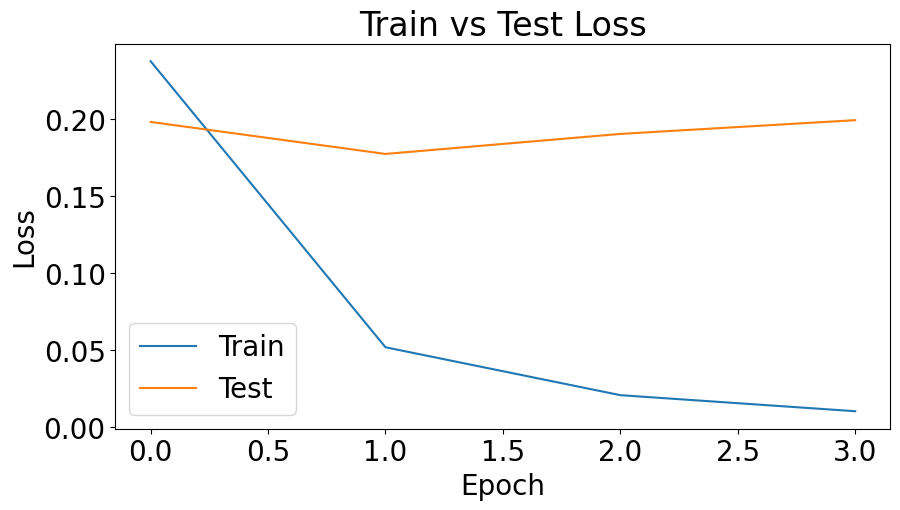

train_loss 0.242 validation_loss 0.189
train_loss 0.053 validation_loss 0.174
train_loss 0.02 validation_loss 0.185
train_loss 0.009 validation_loss 0.194


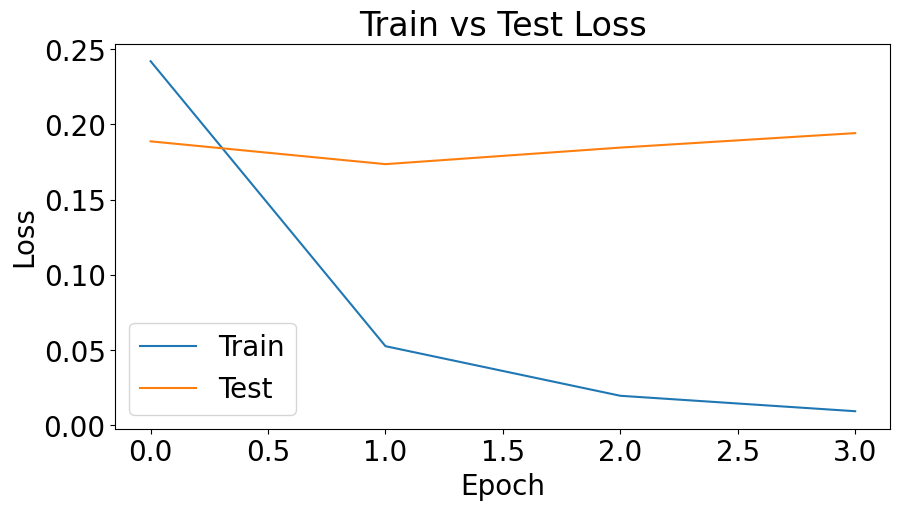

train_loss 0.242 validation_loss 0.177
train_loss 0.053 validation_loss 0.169
train_loss 0.021 validation_loss 0.177
train_loss 0.013 validation_loss 0.189


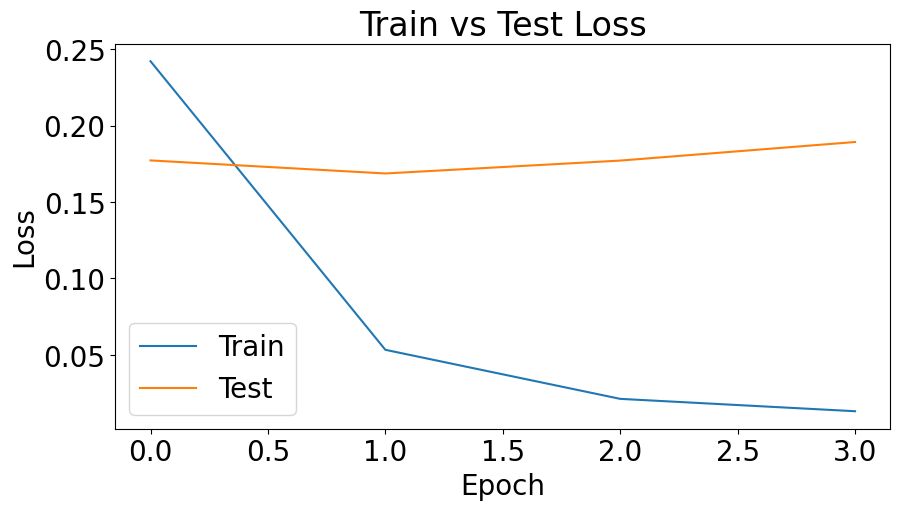

train_loss 0.237 validation_loss 0.199
train_loss 0.051 validation_loss 0.196
train_loss 0.02 validation_loss 0.207
train_loss 0.01 validation_loss 0.221


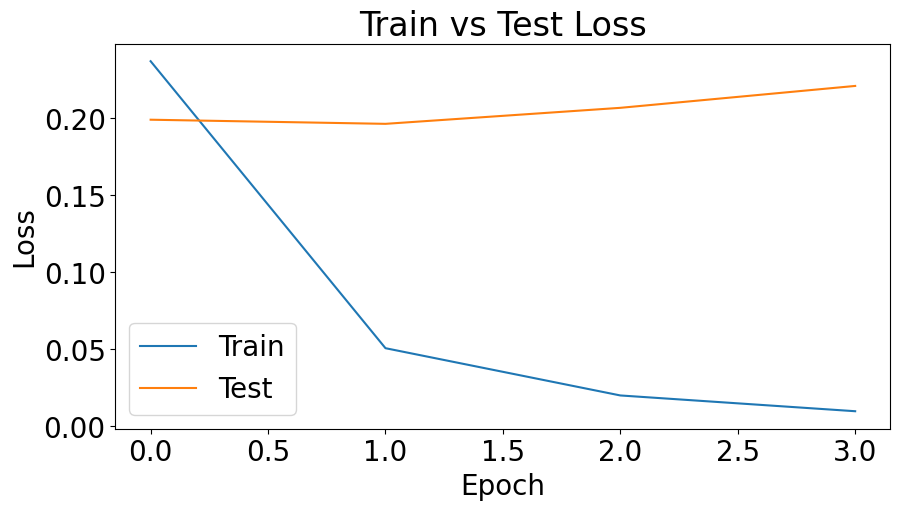

train_loss 0.24 validation_loss 0.206
train_loss 0.052 validation_loss 0.185
train_loss 0.02 validation_loss 0.195
train_loss 0.01 validation_loss 0.208


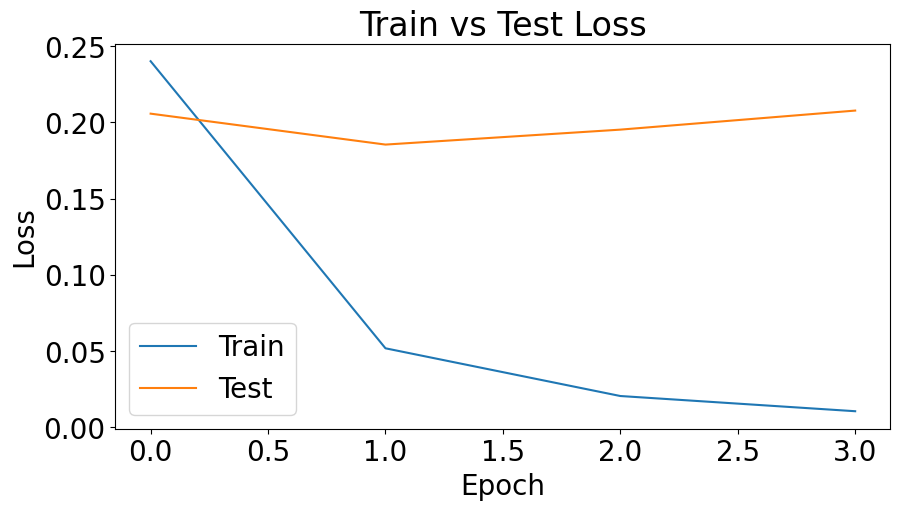

[array([[4789,  159],
       [ 157,  392]]), array([[4733,  241],
       [ 132,  391]]), array([[4731,  194],
       [ 142,  430]]), array([[4729,  208],
       [ 161,  399]]), array([[4762,  190],
       [ 145,  400]])]


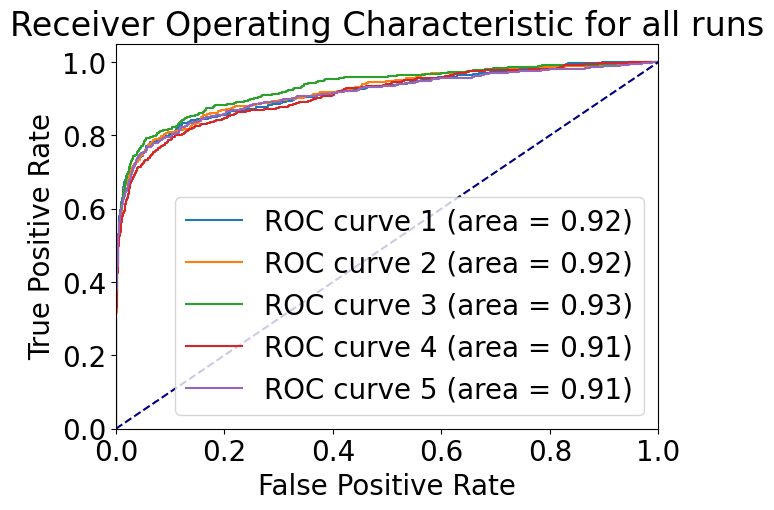

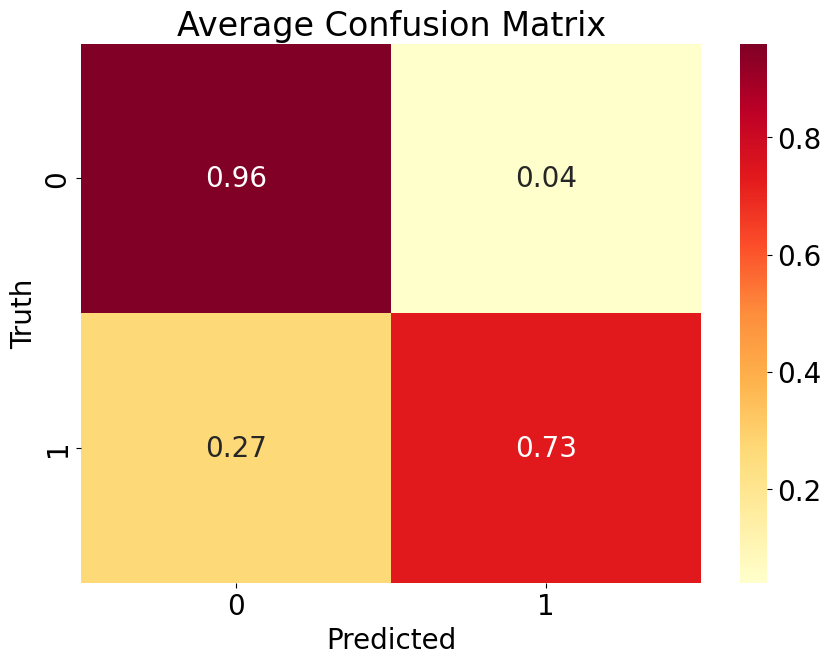

In [181]:
# DPS 
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

print(len(X))
# Set global font size
plt.rcParams.update({'font.size': 20})

# Combine X and y
data = list(zip(X, y))

# Shuffle data
random.shuffle(data)

# Split data into five parts
n = len(data) // 5
data_splits = [data[i * n:(i + 1) * n] for i in range(5)]

# Save all AUCs and confusion matrices
roc_data = []
cms = []

# For each split, use it as test set and the rest as training set
for i in range(5):
    test_data = data_splits[i]
    train_data = [item for sublist in data_splits[:i] + data_splits[i + 1:] for item in sublist]
    
    # Separate X and y
    X_test, y_test = zip(*test_data)
    X_train, y_train = zip(*train_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Run the MLP model
    num_train_epochs = 4
    model, train_losses, validation_losses = run_MLP(
        X_train, X_test, y_train, y_test, batch_size=100, 
        learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

    # Plot train and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_train_epochs), train_losses, label='Train')
    plt.plot(range(num_train_epochs), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Test Loss')
    plt.show()

    # Predict probabilities for the test data
    probs = model.predict_proba(X_test)
    
    # Change the threshold
    threshold = 0.2
    y_pred = np.where(probs[:,1] > threshold, 1, 0)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
    # Calculate confusion matrix
    #y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)

# Plot all AUCs
print(cms)
plt.figure(figsize=(7, 5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f'ROC curve {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all runs')
plt.legend(loc="lower right")
plt.show()

# Calculate the average confusion matrix
avg_cm = sum(cms) / len(cms)

# Normalize the confusion matrix
cm_normalized = normalize(avg_cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Average Confusion Matrix')
plt.show()        

### Predict all cds combination 

In [185]:
# DPS 
X = []
y = []
from tqdm import tqdm
import numpy as np
for gene_pair, label in tqdm(SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass
        
for gene_pair, label in tqdm(Non_SR.items()):
    try:       
        a = cds_features_dic[gene_pair[0]]
        b = cds_features_dic[gene_pair[1]]
        c = cds_pro_features_dic[gene_pair[0]]
        d = cds_pro_features_dic[gene_pair[1]]
        e = cds_3d_features_dic[gene_pair[0]]
        f = cds_3d_features_dic[gene_pair[1]]
                
        X.append(np.concatenate([a,b,c,d,e,f]))
        y.append(label)        
    except:
        #print(gene_pair)
        pass

100%|█████████████████████████████████████████████████████| 24740/24740 [00:11<00:00, 2067.07it/s]


In [186]:
len(X[0])

7184

In [187]:
def run_MLP(X, y, batch_size, learning_rate, weight_decay, num_train_epochs):
    # Apply SMOTE to generate synthetic samples
    smote = SMOTE(sampling_strategy='minority')
    X, y = smote.fit_resample(X, y)

    # create the MLP model
    model = MLPClassifier(hidden_layer_sizes=(256, 32),
                          activation='relu',
                          solver='adam',
                          alpha=weight_decay,
                          batch_size=batch_size,
                          learning_rate='constant',
                          learning_rate_init=learning_rate,
                          power_t=0.5,
                          max_iter=num_train_epochs,  # train for num_train_epochs at a time
                          shuffle=True,
                          random_state=42,
                          tol=1e-7,  # disable early stopping
                          verbose=False, # not print progress messages
                          validation_fraction=0.1,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=1e-8,
                          n_iter_no_change=10,
                          max_fun=15000)

    train_losses = []
    for _ in range(num_train_epochs):
        # Fit the model for one epoch
        model.partial_fit(X, y, classes=np.unique(y))

        # Get the training loss
        train_loss = model.loss_
        train_losses.append(train_loss)
        
        print('train_loss', round(train_loss,3))

    return model, train_losses

# Scale your data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Run the MLP model
num_train_epochs = 4
model, train_losses = run_MLP(
    X, y, batch_size=100, 
    learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

train_loss 0.226
train_loss 0.049
train_loss 0.019
train_loss 0.01


In [205]:
import csv
#count = 0
with open('SRDP_results_all_cds.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['R gene', 'V gene'])  # 写入CSV文件的第一行

    for i in tqdm(common_list):
        count+=1
        x = []
        a = cds_features_dic[i]
        c = cds_pro_features_dic[i]
        e = cds_3d_features_dic[i]   
        for j in common_list:      
            b = cds_features_dic[j]        
            d = cds_pro_features_dic[j]      
            f = cds_3d_features_dic[j]

            x.append(np.concatenate([a,b,c,d,e,f]))
        x = scaler.transform(x)

        # Predict probabilities for the test data
        probs = model.predict_proba(x)

        # Change the threshold
        threshold = 0.2
        y_pred = np.where(probs[:,1] > threshold, 1, 0)

        for j,y in zip(common_list, y_pred):
            if y == 1:
                writer.writerow([i, j])  # 写入i和j到CSV文件中的一行
                



  0%|                                                       | 1/19489 [00:21<114:50:53, 21.22s/it]


In [206]:
import csv
import numpy as np
from multiprocessing import Pool
import pandas as pd

# Split common_list into 10 chunks
def split_list(a_list, n):
    k, m = divmod(len(a_list), n)
    return (a_list[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

chunks = list(split_list(common_list, 10))

def process_chunk(index_chunk):
    index, chunk = index_chunk
    with open(f'SRDP_results_all_cds_{index}.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['R gene', 'V gene'])  # 写 into CSV file's first line

        for i in tqdm(chunk):
            x = []
            a = cds_features_dic[i]
            c = cds_pro_features_dic[i]
            e = cds_3d_features_dic[i]   
            for j in common_list:      
                b = cds_features_dic[j]        
                d = cds_pro_features_dic[j]      
                f = cds_3d_features_dic[j]

                x.append(np.concatenate([a,b,c,d,e,f]))
            x = scaler.transform(x)

            # Predict probabilities for the test data
            probs = model.predict_proba(x)

            # Change the threshold
            threshold = 0.2
            y_pred = np.where(probs[:,1] > threshold, 1, 0)

            for j,y in zip(common_list, y_pred):
                if y == 1:
                    writer.writerow([i, j])  # 写入i和j到CSV文件中的一行

# Use multiprocessing Pool
with Pool() as p:
    p.map(process_chunk, enumerate(chunks))

100%|███████████████████████████████████████████████████████| 1949/1949 [7:11:55<00:00, 13.30s/it]


In [207]:
# Combine all CSV files into one
combined_csv = pd.concat([pd.read_csv(f'SRDP_results_all_cds_{i}.csv') for i in range(10)])
combined_csv.to_csv("SRDP_results_all_cds_combined.csv", index=False)

In [208]:
len(common_list)

19489

In [209]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('SRDP_results_all_cds_combined.csv')
len(df)

13161666

In [216]:
a = 0
for i in range(10):
    df = pd.read_csv('SRDP_results_all_cds_'+str(i)+'.csv')
    print(len(df))
    a+=len(df)
print(a)

1282504
1353803
1329772
1321778
1293862
1312853
1321595
1262931
1311885
1370683
13161666


SR candidates ratio

In [218]:
13161666/(19489*19489)

0.034652275169289495

In [215]:
19489*19489

379821121